# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 5 aparelhos (de maior consumo de energia);
        * *Amostras:* Blocos de 1 minuto e 30 segundos (90 segundos - 30 'chunks', dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from datetime import datetime
from time import time
from tqdm import tqdm_notebook, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

import random as rn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import *

from pyts.image import RecurrencePlot, GramianAngularField

DATASET_PATH = 'datasets/phd'
SEED = 33
TEST_SIZE = 0.25
EPOCHS = 100
BATCH_SIZE = 32

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
# BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

# sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
# sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

# from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


In [2]:
tf.__version__

'2.0.0'

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
# tf.debugging.set_log_device_placement(False)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            

#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carregando os dados

In [6]:
# Reading pre-processed data
print("Loading mains data...")
mains_info = [
    {"channel": 1, "name": "mains 1"},
    {"channel": 2, "name": "mains 2"}
]
mains = []
for m in tqdm(mains_info):
    file_chunks = glob(os.path.join(DATASET_PATH, "{}-*.npy".format(m["channel"])))[0]
    mains.append(np.load(file_chunks))
mains = np.array(mains)
mains_idx = 0
mains_agg = StandardScaler().fit_transform(np.sum(mains, axis=0))

# For the development of the proposed system based on a Neural Convolutional Network to identify the equipment, 
# in an initial phase, 6 equipment were chosen: 
# microwave, oven, dishwasher, air conditioning, washer / dryer and refrigerator. 
# The chosen equipment can be considered the most energy consuming in a residence. According to Batra [16], it is 
# necessary to prioritize the identification of equipment with higher energy consumption in the residences, since 
# these devices contribute with the most significant characteristics in the aggregate load, and the other appliances, 
# with lower consumption, can only be considered as noise in the load total aggregate.

print("Loading appliances data...")
labels_power = []
labels_binary = []
valid_appliances = []
#appliances = joblib.load(os.path.join(DATASET_PATH, "appliances.pkl"))
appliances=[
    {"channel": 7, "name": "refrigerator"},
    {"channel": 9, "name": "dishwasher"},
    {"channel": 13, "name": "washer dryer 1"},
    {"channel": 14, "name": "washer dryer 2"},
    {"channel": 16, "name": "microwave"}
]
for a in tqdm(appliances):
    #file_total = glob(os.path.join(DATASET_PATH, "{}-*total.npy".format(a["channel"])))[0]
    #labels_power.append(np.load(file_total))

    file_binary = glob(os.path.join(DATASET_PATH, "{}-*_binary.npy".format(a["channel"])))[0]
    labels_binary.append(np.load(file_binary))

    valid_appliances.append(a["name"])
    
#labels_power = np.array(labels_power).T
labels_binary = np.array(labels_binary).T
## TODO: Adaptative length ny appliance...
# Microwave 191
# Dishwasher 588
# Refrigerator 2401

Loading mains data...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.31it/s]


Loading appliances data...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 104.11it/s]


# Funções

In [7]:
def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)


    
def classification_report_appliance(y_test, y_pred, label = None):
    
    final_performance = []
    
    test = y_test
    predicted = y_pred
    #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)   
    auc_ = roc_auc_score(test, predicted)
    y_i = y_test
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]

    final_performance = [[
        label, 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("CLASSIFIER PERFORMANCE {} MODEL:".format(label.upper()))
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

#     print("")
#     print("OVERALL AVERAGE PERFORMANCE:")
#     display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON):")
    
    cms = confusion_matrix(y_test, y_pred)
    for i, a in enumerate([label]):
        print("")
        print(" - {}:".format(a))
        print(cms)

In [8]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def calculate_metrics(estimator, X_test, y_test):
    y_pred = np.array(estimator.model.predict(X_test).round()) # TODO: corrigir '.model' (https://github.com/keras-team/keras/issues/9331)
    return (
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred, average='macro'), 
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='micro'),
        f1_score(y_test, y_pred, average='macro')
    )

def global_scorer(estimator, X_test, y_test):
    acc, prec, rec, f1_micro, f1m = calculate_metrics(estimator, X_test, y_test)
    return acc, prec, rec, f1_micro, f1m

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    acc, prec, rec, f1_micro, f1m = global_scorer(model, X_test, y_test)
    return [acc, prec, rec, f1_micro, f1m]

#label_encoder = LabelEncoder()

kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state= 33
)

# Deep Learning

## Funções Auxiliares

In [10]:
import shutil
import stat
from tensorflow.keras import optimizers
from ctypes import windll

def rmtree(top):
    for root, dirs, files in os.walk(top, topdown=False):
        for name in files:
            filename = os.path.join(root, name)
            os.chmod(filename, stat.S_IWUSR)
            os.remove(filename)
        for name in dirs:
            os.rmdir(os.path.join(root, name))
    os.rmdir(top)   
    
def get_ppi():
    LOGPIXELSX = 88
    LOGPIXELSY = 90
    user32 = windll.user32
    user32.SetProcessDPIAware()
    dc = user32.GetDC(0)   
    pix_per_inch = windll.gdi32.GetDeviceCaps(dc, LOGPIXELSX)
    #print("Horizontal DPI is", windll.gdi32.GetDeviceCaps(dc, LOGPIXELSX))
    #print("Vertical DPI is", windll.gdi32.GetDeviceCaps(dc, LOGPIXELSY))
    user32.ReleaseDC(0, dc)
    return pix_per_inch

def plot_serie(serie, image_size_px=128, dpi=100):
    fig = plt.figure(figsize=(image_size_px/dpi, image_size_px/dpi), dpi=dpi);
    plt.plot(serie);
#     plt.xlim([0, mains_agg.shape[1]]);
    plt.axis("off");
    return fig

class ImageProcessing():
    def __init__(self, image_size_px = 128, Y = None):
        self.image_size_px = image_size_px
        
    def fit(self, images, Y = None, mode = "train"):
        return self

    def transform(self, images, Y = None, mode = 'train'):
        processed_images = []
        try:
#             for idx, image in tqdm_notebook(enumerate(images), total=len(images)):
#                 img = np.stack((image,) * 3, -1)
#                 processed_images.append(img/255)
            if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
                shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
                
            for idx, image in tqdm_notebook(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
                image_path = os.path.join( 
                        HYPOTHESIS_RESOURCES_PATH, "temp",
                        "{}_{}_color.png".format(idx, mode) 
                    )
                imsave(
                    image_path, 
                    arr=image
                )
                # Reading image in 3channel RGB mode
                img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
                img = keras_image.img_to_array(img)
                img = img/255                
                #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
                processed_images.append(img)
            
            shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            
        except Exception as err:
            print('ImageProcessing.transform(): {}'.format(err))
            
        return np.array(processed_images)
        #return processed_images

    def fit_transform(self, images, Y = None, mode = 'train'):
        self.fit(images)
        return self.transform(images, Y, mode)

## Arquiteturas de CNN

In [19]:
#from keras.callbacks import TensorBoard

#################################### MODELOS 
def dcnn_multilabel(input_shape_ = (128,128,3), output_layer_length = len(valid_appliances)):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_layer_length, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
#     model = Sequential()

#     model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=input_shape_))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(output_layer_length, activation='softmax'))

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

# For training of the CNN a fixed size window as input layer is required. In the
# experiments 28×28, 56×56 and 64×64 pixel input, depend on the data, are used. Both layers contain 32 feature
# maps with 3×3 convolution (32×3×3), MaxPooling of size 2×2 and Dropout = 0.25. The fully connected neural
# layer contains 128 hidden neurons and c output neurons with Dropout = 0.5.
def dcnn_appliance(input_shape_ = (128,128,3), loss_function = 'binary_crossentropy'):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=['accuracy', f1])
    
    return model

################################## ALTERNATIVE ARCHITECTURES ##################################
def vgg_multilabel():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(len(valid_appliances), activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1]
    )
    
    return model

def vgg_appliance():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = (128, 128, 3)
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    
#     #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#     x=Dense(1024,activation='relu')(x) #dense layer 2
#     x=Dense(512,activation='relu')(x) #dense layer 3
#     #output_layer = Dense(2, activation='softmax')(x) #final layer with softmax activation
    
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_multilabel( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(len(valid_appliances), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
    
    return model

def tiled_cnn_appliance( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    
    return model

## Imagens Série

In [11]:
# https://github.com/philipperemy/tensorflow-cnn-time-series/
import skimage

mode = "_"
dpi = get_ppi()
image_size_px = 128
processed_images = []
series_images = []

In [8]:
if not os.path.isfile( os.path.join(DATASET_PATH, "serie_images.npy") ) or \
    input("Já existe um arquivo processado. Deseja gerar as imagens novamente? S/N: ").upper() == "S":
    
    print("Generating series images from data...")
    try:
        
        plt.style.use('default')
        plt.ioff()
        
        if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
            rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
        os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))

        for idx in tqdm_notebook(range(mains_agg.shape[0])):
            image_path = os.path.join( 
                    HYPOTHESIS_RESOURCES_PATH, "temp",
                    "{}_{}_color.png".format(idx, mode) 
                )
            # Plot/Saving figure...
            # fig = plot_serie(mains_agg[idx, :], image_size_px, dpi)
            fig = plt.figure(figsize=(image_size_px/dpi, image_size_px/dpi), dpi=dpi);
            plt.plot(mains_agg[idx, :]);
            plt.savefig(image_path, dpi=dpi);#bbox_inches='tight', pad_inches = 0, dpi=dpi);
            plt.close(fig)

            # Reading image in 3channel RGB mode
            #img = keras_image.load_img( image_path, target_size=(image_size_px, image_size_px , 3))
            #img = keras_image.img_to_array(img)
            #img = img/255    
            img = skimage.io.imread(image_path).astype(float)
            img = skimage.transform.resize(img, (image_size_px, image_size_px , 3), mode='constant')
            img /= 255
            #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
            processed_images.append(img)
            #break
        plt.ion()
        plt.style.use('ggplot')
        
        #rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))

    except Exception as err:
        print('ImageProcessing.transform(): {}'.format(err))

    series_images = np.array(processed_images)
    np.save(os.path.join(DATASET_PATH, "serie_images.npy"), series_images)
    
else:
    print("Loading series images...")
    series_images = np.load(os.path.join(DATASET_PATH, "serie_images.npy"))

Já existe um arquivo processado. Deseja gerar as imagens novamente? S/N: N
Loading series images...


In [9]:
gaf_images = series_images

### Classificador Multilabel

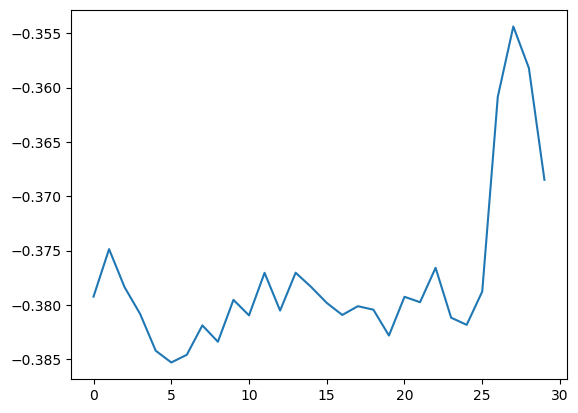

In [114]:
import matplotlib
plt.style.use('default')
matplotlib.use('Agg')
plt.plot(mains_agg[0,:])

In [ ]:
plt.imshow(series_images[3, :]);
plt.axis('off');

### Classificadores Especialistas (Binários)


---> Splitting data (train/test)...
---> Training the `refrigerator` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 9s - loss: 0.3537 - accuracy: 0.8958 - f1: 0.9413 - val_loss: 0.1950 - val_accuracy: 0.9674 - val_f1: 0.9802
Epoch 2/100
5145/5145 - 5s - loss: 0.1673 - accuracy: 0.9460 - f1: 0.9681 - val_loss: 0.1569 - val_accuracy: 0.9679 - val_f1: 0.9808
Epoch 3/100
5145/5145 - 5s - loss: 0.1443 - accuracy: 0.9565 - f1: 0.9745 - val_loss: 0.1388 - val_accuracy: 0.9685 - val_f1: 0.9809
Epoch 4/100
5145/5145 - 5s - loss: 0.1430 - accuracy: 0.9588 - f1: 0.9755 - val_loss: 0.1301 - val_accuracy: 0.9679 - val_f1: 0.9811
Epoch 5/100
5145/5145 - 5s - loss: 0.1322 - accuracy: 0.9638 - f1: 0.9788 - val_loss: 0.1229 - val_accuracy: 0.9709 - val_f1: 0.9828
Epoch 6/100
5145/5145 - 5s - loss: 0.1248 - accuracy: 0.9644 - f1: 0.9790 - val_loss: 0.1190 - val_accuracy: 0.9744 - val_f1: 0.9848
Epoch 7/100
5145/5145 - 5s - loss: 0.1216 - accuracy: 0.9699 - f1: 0.9823 

Epoch 62/100
5145/5145 - 5s - loss: 0.0111 - accuracy: 0.9963 - f1: 0.9977 - val_loss: 0.4153 - val_accuracy: 0.9767 - val_f1: 0.9861
Epoch 63/100
5145/5145 - 5s - loss: 0.0058 - accuracy: 0.9981 - f1: 0.9988 - val_loss: 0.5399 - val_accuracy: 0.9773 - val_f1: 0.9864
Epoch 64/100
5145/5145 - 5s - loss: 0.0070 - accuracy: 0.9984 - f1: 0.9991 - val_loss: 0.4230 - val_accuracy: 0.9697 - val_f1: 0.9820
Epoch 65/100
5145/5145 - 5s - loss: 0.0060 - accuracy: 0.9983 - f1: 0.9990 - val_loss: 0.5032 - val_accuracy: 0.9744 - val_f1: 0.9848
Epoch 66/100
5145/5145 - 5s - loss: 0.0044 - accuracy: 0.9990 - f1: 0.9994 - val_loss: 0.5357 - val_accuracy: 0.9767 - val_f1: 0.9861
Epoch 67/100
5145/5145 - 5s - loss: 0.0054 - accuracy: 0.9981 - f1: 0.9989 - val_loss: 0.4468 - val_accuracy: 0.9744 - val_f1: 0.9845
Epoch 68/100
5145/5145 - 5s - loss: 0.0074 - accuracy: 0.9979 - f1: 0.9987 - val_loss: 0.4437 - val_accuracy: 0.9749 - val_f1: 0.9852
Epoch 69/100
5145/5145 - 5s - loss: 0.0046 - accuracy: 0.9984 

,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,97.73,97.78,99.59,98.68,95.29,0.02,0.93,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 221   33]
 [   6 1456]]


---> Splitting data (train/test)...
---> Training the `dishwasher` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.4131 - accuracy: 0.9203 - f1: 0.9572 - val_loss: 0.2097 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 2/100
5145/5145 - 5s - loss: 0.1941 - accuracy: 0.9240 - f1: 0.9597 - val_loss: 0.1946 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 3/100
5145/5145 - 5s - loss: 0.1812 - accuracy: 0.9240 - f1: 0.9599 - val_loss: 0.2048 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 4/100
5145/5145 - 5s - loss: 0.1742 - accuracy: 0.9259 - f1: 0.9609 - val_loss: 0.1665 - val_accuracy: 0.9324 - val_f1: 0.9642
Epoch 5/100
5145/5145 - 5s - loss: 0.1685 - accuracy: 0.9308 - f1: 0.9634 - val_loss: 0.1651 - val_accuracy: 0.9324 - val_f1: 0.9642
Epoch 6/100
5145/5145 - 5s - loss: 0.1598 - accuracy: 0.9316 - f1: 0.9638 - val_loss: 0.1648 - val_accuracy: 0.9324 - val_f1: 0.9642
Ep

Epoch 61/100
5145/5145 - 5s - loss: 0.0224 - accuracy: 0.9932 - f1: 0.9963 - val_loss: 0.4511 - val_accuracy: 0.9207 - val_f1: 0.9567
Epoch 62/100
5145/5145 - 5s - loss: 0.0264 - accuracy: 0.9909 - f1: 0.9950 - val_loss: 0.4340 - val_accuracy: 0.9202 - val_f1: 0.9562
Epoch 63/100
5145/5145 - 5s - loss: 0.0317 - accuracy: 0.9899 - f1: 0.9945 - val_loss: 0.4682 - val_accuracy: 0.9260 - val_f1: 0.9596
Epoch 64/100
5145/5145 - 5s - loss: 0.0235 - accuracy: 0.9936 - f1: 0.9965 - val_loss: 0.5463 - val_accuracy: 0.9248 - val_f1: 0.9590
Epoch 65/100
5145/5145 - 5s - loss: 0.0213 - accuracy: 0.9936 - f1: 0.9964 - val_loss: 0.4404 - val_accuracy: 0.9237 - val_f1: 0.9581
Epoch 66/100
5145/5145 - 5s - loss: 0.0222 - accuracy: 0.9938 - f1: 0.9966 - val_loss: 0.4432 - val_accuracy: 0.9207 - val_f1: 0.9569
Epoch 67/100
5145/5145 - 5s - loss: 0.0247 - accuracy: 0.9918 - f1: 0.9955 - val_loss: 0.4359 - val_accuracy: 0.9231 - val_f1: 0.9578
Epoch 68/100
5145/5145 - 5s - loss: 0.0237 - accuracy: 0.9922 

W1029 22:30:13.973160  3880 callbacks.py:990] Can save best model only with val_f1 available, skipping.


KeyboardInterrupt: 

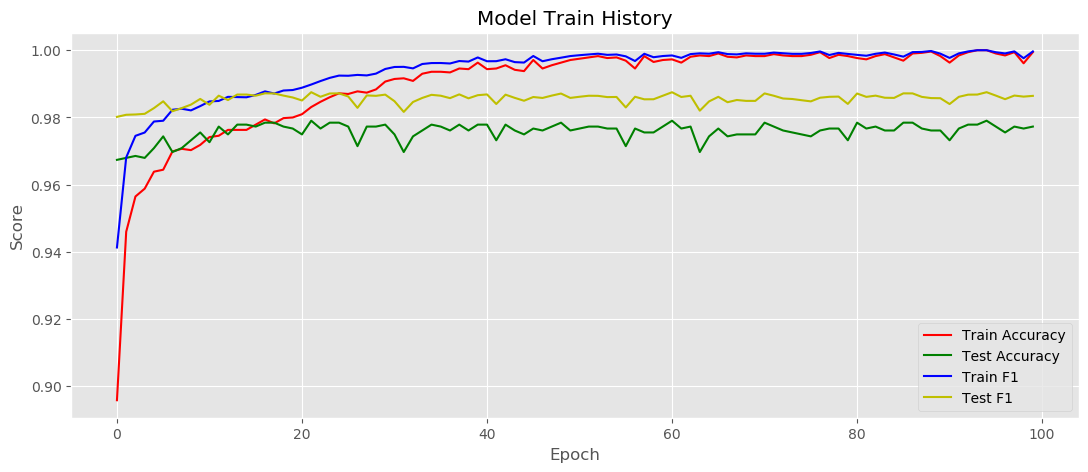

In [118]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-best.h5".format("series", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
    
    # Persisting model
    model.save("models/{}-{}-{}.h5".format("series", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

## Imagens GAF

In [12]:
if not os.path.isfile( os.path.join(DATASET_PATH, "gaf_images.npy") ) or \
    input("Já existe um arquivo processado. Deseja gerar as imagens novamente? S/N: ").upper() == "S":
    
    print("Generating GAF images from data...")
    gaf_pipeline = Pipeline([
        ('gramianangularfield', GramianAngularField()),
        ('imageprocessing', ImageProcessing())
    ])
    series_images = gaf_pipeline.fit_transform(mains_agg, imageprocessing__mode = "_")
    np.save(os.path.join(DATASET_PATH, "gaf_images.npy"), series_images)
    
else:
    print("Loading GAF images...")
    series_images = np.load(os.path.join(DATASET_PATH, "gaf_images.npy"))

Já existe um arquivo processado. Deseja gerar as imagens novamente? S/N: N
Loading GAF images...


==================== AGGREGATED MAINS INFO ====================

Mean scaled matrix: -0.00000000


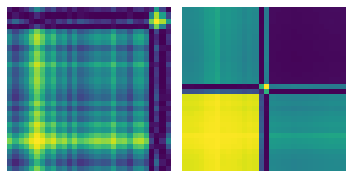

In [13]:
print("="*20, "AGGREGATED MAINS INFO", "="*20)

print()
print('Mean scaled matrix: {:.8f}'.format( np.mean(mains_agg) ))

idx0 = 0
idx1 = 88

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axes[0].imshow(series_images[idx0], origin="lower")
axes[0].axis('off');
axes[1].imshow(series_images[idx1], origin="lower");
axes[1].axis('off');
fig.tight_layout();

==================== MAINS 0 INFO ====================

Mean original matrix: 247.82319641


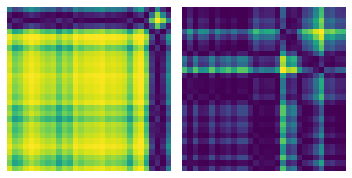

In [14]:
print("="*20, "MAINS {} INFO".format(mains_idx), "="*20)

print()
print('Mean original matrix: {:.8f}'.format( np.mean(mains[mains_idx,:,:]) ))

images = GramianAngularField().fit_transform( mains[mains_idx, :100, :] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axes[0].imshow(images[idx0], origin="lower")
axes[0].axis('off');
axes[1].imshow(images[idx1], origin="lower");
axes[1].axis('off');
fig.tight_layout();

### Classificador Multilabel

In [15]:
series_images.shape

(6861, 128, 128, 3)

---> Splitting data (train/test)...
---> Training the `GAF-multilabel` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 0.1820 - accuracy: 0.9380 - f1: 0.9455 - val_loss: 0.1679 - val_accuracy: 0.9497 - val_f1: 0.9552
Epoch 2/100
5145/5145 - 4s - loss: 0.1341 - accuracy: 0.9548 - f1: 0.9605 - val_loss: 0.1398 - val_accuracy: 0.9555 - val_f1: 0.9609
Epoch 3/100
5145/5145 - 4s - loss: 0.1225 - accuracy: 0.9589 - f1: 0.9640 - val_loss: 0.1243 - val_accuracy: 0.9572 - val_f1: 0.9624
Epoch 4/100
5145/5145 - 4s - loss: 0.1152 - accuracy: 0.9599 - f1: 0.9650 - val_loss: 0.1445 - val_accuracy: 0.9573 - val_f1: 0.9625
Epoch 5/100
5145/5145 - 4s - loss: 0.1088 - accuracy: 0.9613 - f1: 0.9662 - val_loss: 0.1390 - val_accuracy: 0.9565 - val_f1: 0.9618
Epoch 6/100
5145/5145 - 4s - loss: 0.1057 - accuracy: 0.9626 - f1: 0.9673 - val_loss: 0.1278 - val_accuracy: 0.9562 - val_f1: 0.9616
Epoch 7/100
5145/5145 - 4s - loss: 0.1008 - accuracy: 0.9624 - f1: 0.9671

Epoch 62/100
5145/5145 - 4s - loss: 0.0173 - accuracy: 0.9931 - f1: 0.9939 - val_loss: 0.3750 - val_accuracy: 0.9563 - val_f1: 0.9617
Epoch 63/100
5145/5145 - 4s - loss: 0.0191 - accuracy: 0.9923 - f1: 0.9932 - val_loss: 0.3571 - val_accuracy: 0.9550 - val_f1: 0.9605
Epoch 64/100
5145/5145 - 4s - loss: 0.0189 - accuracy: 0.9928 - f1: 0.9937 - val_loss: 0.3385 - val_accuracy: 0.9542 - val_f1: 0.9598
Epoch 65/100
5145/5145 - 4s - loss: 0.0178 - accuracy: 0.9927 - f1: 0.9936 - val_loss: 0.3743 - val_accuracy: 0.9549 - val_f1: 0.9605
Epoch 66/100
5145/5145 - 4s - loss: 0.0157 - accuracy: 0.9932 - f1: 0.9941 - val_loss: 0.4354 - val_accuracy: 0.9573 - val_f1: 0.9626
Epoch 67/100
5145/5145 - 4s - loss: 0.0188 - accuracy: 0.9924 - f1: 0.9932 - val_loss: 0.3907 - val_accuracy: 0.9537 - val_f1: 0.9595
Epoch 68/100
5145/5145 - 4s - loss: 0.0205 - accuracy: 0.9920 - f1: 0.9929 - val_loss: 0.3664 - val_accuracy: 0.9564 - val_f1: 0.9618
Epoch 69/100
5145/5145 - 4s - loss: 0.0158 - accuracy: 0.9937 

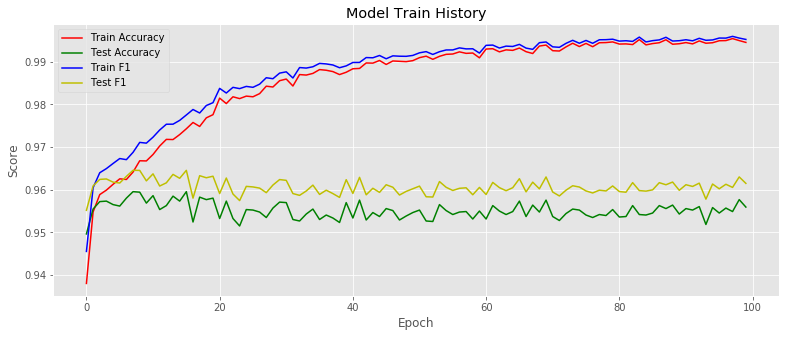

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,97.79,97.91,99.52,98.71,95.45,0.02,0.94,255,1461
1,dishwasher,91.72,93.84,97.32,95.55,68.44,0.08,0.65,150,1566
2,washer dryer 1,96.10,29.17,12.28,17.28,57.64,0.04,0.56,1659,57
3,washer dryer 2,94.11,23.40,14.47,17.89,57.42,0.06,0.56,1640,76
4,microwave,98.25,98.77,99.47,99.12,63.84,0.02,0.61,27,1689



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,95.59,68.62,64.61,65.71,68.56,0.04,0.66,746.2,969.8
max,98.25,98.77,99.52,99.12,95.45,0.08,0.94,1659.0,1689.0
min,91.72,23.40,12.28,17.28,57.42,0.02,0.56,27.0,57.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - refrigerator:
[[ 224   31]
 [   7 1454]]

 - dishwasher:
[[  50  100]
 [  42 1524]]

 - washer dryer 1:
[[1642   17]
 [  50    7]]

 - washer dryer 2:
[[1604   36]
 [  65   11]]

 - microwave:
[[   6   21]
 [   9 1680]]


In [22]:
print("---> Splitting data (train/test)...")
X_train, X_test, y_train, y_test = train_test_split(
    series_images, labels_binary,
    #stratify = labels_binary[:, i],
    random_state=SEED, test_size=TEST_SIZE#, shuffle=True
)

print("---> Training the `GAF-multilabel` model...\n")

multilabel_gaf_model = dcnn_multilabel()
#print(multilabel_gaf_model.summary())
callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
    ModelCheckpoint(
        filepath="models/{}-{}-best.h5".format("gaf", "multilabel"), 
        monitor='val_f1', 
        save_best_only=True
    )
]

callback = multilabel_gaf_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose = 2, callbacks = callbacks_
)


# Persisting model
multilabel_gaf_model.save("models/{}-{}.h5".format("gaf", "multilabel"))

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multilabel_gaf_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas (Binários)


---> Splitting data (train/test)...
---> Training the `refrigerator` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 10s - loss: 0.3121 - accuracy: 0.8791 - f1: 0.9325 - val_loss: 0.2409 - val_accuracy: 0.9540 - val_f1: 0.9726
Epoch 2/100
5145/5145 - 4s - loss: 0.2105 - accuracy: 0.9283 - f1: 0.9579 - val_loss: 0.2222 - val_accuracy: 0.9441 - val_f1: 0.9658
Epoch 3/100
5145/5145 - 4s - loss: 0.1806 - accuracy: 0.9392 - f1: 0.9645 - val_loss: 0.1760 - val_accuracy: 0.9545 - val_f1: 0.9727
Epoch 4/100
5145/5145 - 4s - loss: 0.1625 - accuracy: 0.9493 - f1: 0.9700 - val_loss: 0.1537 - val_accuracy: 0.9615 - val_f1: 0.9769
Epoch 5/100
5145/5145 - 4s - loss: 0.1487 - accuracy: 0.9553 - f1: 0.9738 - val_loss: 0.1454 - val_accuracy: 0.9598 - val_f1: 0.9759
Epoch 6/100
5145/5145 - 4s - loss: 0.1404 - accuracy: 0.9596 - f1: 0.9762 - val_loss: 0.1388 - val_accuracy: 0.9650 - val_f1: 0.9793
Epoch 7/100
5145/5145 - 4s - loss: 0.1417 - accuracy: 0.9584 - f1: 0.9755

Epoch 62/100
5145/5145 - 4s - loss: 0.0277 - accuracy: 0.9916 - f1: 0.9950 - val_loss: 0.3098 - val_accuracy: 0.9726 - val_f1: 0.9836
Epoch 63/100
5145/5145 - 4s - loss: 0.0193 - accuracy: 0.9936 - f1: 0.9962 - val_loss: 0.2786 - val_accuracy: 0.9691 - val_f1: 0.9813
Epoch 64/100
5145/5145 - 4s - loss: 0.0226 - accuracy: 0.9930 - f1: 0.9959 - val_loss: 0.2898 - val_accuracy: 0.9674 - val_f1: 0.9806
Epoch 65/100
5145/5145 - 4s - loss: 0.0243 - accuracy: 0.9922 - f1: 0.9954 - val_loss: 0.3153 - val_accuracy: 0.9738 - val_f1: 0.9841
Epoch 66/100
5145/5145 - 4s - loss: 0.0202 - accuracy: 0.9934 - f1: 0.9961 - val_loss: 0.3087 - val_accuracy: 0.9714 - val_f1: 0.9829
Epoch 67/100
5145/5145 - 4s - loss: 0.0217 - accuracy: 0.9928 - f1: 0.9957 - val_loss: 0.3061 - val_accuracy: 0.9709 - val_f1: 0.9825
Epoch 68/100
5145/5145 - 4s - loss: 0.0219 - accuracy: 0.9940 - f1: 0.9964 - val_loss: 0.3046 - val_accuracy: 0.9650 - val_f1: 0.9792
Epoch 69/100
5145/5145 - 4s - loss: 0.0229 - accuracy: 0.9930 

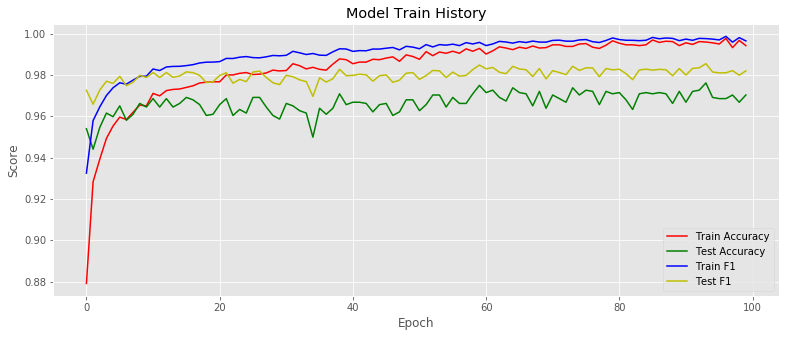

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,97.03,97.7,98.84,98.27,93.94,0.03,0.93,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 220   34]
 [  17 1445]]


---> Splitting data (train/test)...
---> Training the `dishwasher` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.2962 - accuracy: 0.9190 - f1: 0.9562 - val_loss: 0.2568 - val_accuracy: 0.9155 - val_f1: 0.9551
Epoch 2/100
5145/5145 - 4s - loss: 0.1950 - accuracy: 0.9213 - f1: 0.9580 - val_loss: 0.2088 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 3/100
5145/5145 - 4s - loss: 0.1838 - accuracy: 0.9240 - f1: 0.9598 - val_loss: 0.2098 - val_accuracy: 0.9184 - val_f1: 0.9555
Epoch 4/100
5145/5145 - 4s - loss: 0.1787 - accuracy: 0.9254 - f1: 0.9604 - val_loss: 0.2053 - val_accuracy: 0.9237 - val_f1: 0.9593
Epoch 5/100
5145/5145 - 4s - loss: 0.1732 - accuracy: 0.9263 - f1: 0.9610 - val_loss: 0.1826 - val_accuracy: 0.9277 - val_f1: 0.9615
Epoch 6/100
5145/5145 - 4s - loss: 0.1651 - accuracy: 0.9279 - f1: 0.9618 - val_loss: 0.1844 - val_accuracy: 0.9283 - val_f1: 0.9618
Ep

Epoch 61/100
5145/5145 - 4s - loss: 0.0302 - accuracy: 0.9872 - f1: 0.9929 - val_loss: 0.4937 - val_accuracy: 0.9085 - val_f1: 0.9496
Epoch 62/100
5145/5145 - 4s - loss: 0.0317 - accuracy: 0.9872 - f1: 0.9929 - val_loss: 0.4964 - val_accuracy: 0.9126 - val_f1: 0.9522
Epoch 63/100
5145/5145 - 4s - loss: 0.0295 - accuracy: 0.9883 - f1: 0.9936 - val_loss: 0.5603 - val_accuracy: 0.9190 - val_f1: 0.9560
Epoch 64/100
5145/5145 - 4s - loss: 0.0286 - accuracy: 0.9881 - f1: 0.9935 - val_loss: 0.5040 - val_accuracy: 0.9138 - val_f1: 0.9525
Epoch 65/100
5145/5145 - 4s - loss: 0.0365 - accuracy: 0.9850 - f1: 0.9917 - val_loss: 0.5289 - val_accuracy: 0.9196 - val_f1: 0.9560
Epoch 66/100
5145/5145 - 4s - loss: 0.0259 - accuracy: 0.9911 - f1: 0.9951 - val_loss: 0.5129 - val_accuracy: 0.9172 - val_f1: 0.9549
Epoch 67/100
5145/5145 - 4s - loss: 0.0292 - accuracy: 0.9878 - f1: 0.9933 - val_loss: 0.5286 - val_accuracy: 0.9073 - val_f1: 0.9494
Epoch 68/100
5145/5145 - 4s - loss: 0.0380 - accuracy: 0.9860 

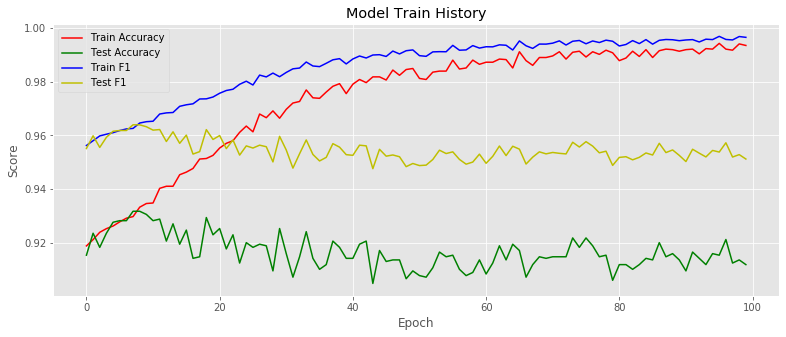

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,91.2,95.32,95.14,95.23,69.13,0.09,0.69,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  57   74]
 [  77 1508]]


---> Splitting data (train/test)...
---> Training the `washer dryer 1` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.2147 - accuracy: 0.9605 - f1: 0.0181 - val_loss: 0.1519 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 0.1138 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 0.1288 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 0.1097 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 0.1250 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 0.1068 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 0.1547 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 5/100
5145/5145 - 4s - loss: 0.1038 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 0.1166 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 6/100
5145/5145 - 4s - loss: 0.0996 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 0.1292 

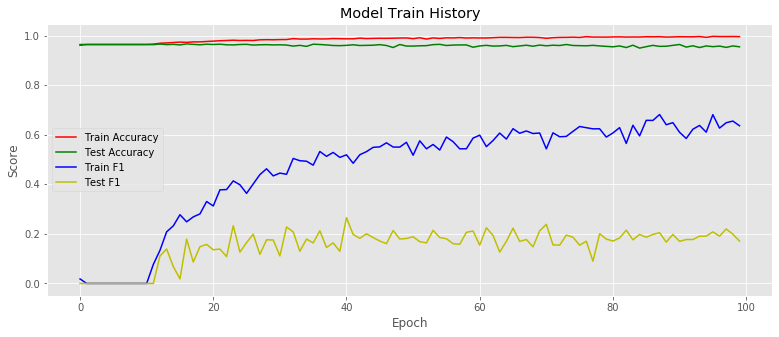

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,95.45,32.61,24.19,27.78,62.72,0.05,0.61,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1623   31]
 [  47   15]]


---> Splitting data (train/test)...
---> Training the `washer dryer 2` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 0.1977 - accuracy: 0.9506 - f1: 0.0012 - val_loss: 0.1977 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 0.1481 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 0.1793 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 0.1426 - accuracy: 0.9534 - f1: 0.0087 - val_loss: 0.1559 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 0.1338 - accuracy: 0.9534 - f1: 0.0072 - val_loss: 0.1502 - val_accuracy: 0.9528 - val_f1: 0.0185
Epoch 5/100
5145/5145 - 4s - loss: 0.1294 - accuracy: 0.9534 - f1: 0.0195 - val_loss: 0.1384 - val_accuracy: 0.9516 - val_f1: 0.0123
Epoch 6/100
5145/5145 - 4s - loss: 0.1247 - accuracy: 0.9530 - f1: 0.0239 - val_loss: 0.1218 - val_accuracy: 0.95

Epoch 61/100
5145/5145 - 4s - loss: 0.0232 - accuracy: 0.9914 - f1: 0.7272 - val_loss: 0.3941 - val_accuracy: 0.9458 - val_f1: 0.2951
Epoch 62/100
5145/5145 - 4s - loss: 0.0227 - accuracy: 0.9914 - f1: 0.6578 - val_loss: 0.3778 - val_accuracy: 0.9481 - val_f1: 0.3006
Epoch 63/100
5145/5145 - 4s - loss: 0.0246 - accuracy: 0.9907 - f1: 0.7021 - val_loss: 0.3610 - val_accuracy: 0.9452 - val_f1: 0.2846
Epoch 64/100
5145/5145 - 4s - loss: 0.0176 - accuracy: 0.9926 - f1: 0.7282 - val_loss: 0.3701 - val_accuracy: 0.9516 - val_f1: 0.3012
Epoch 65/100
5145/5145 - 4s - loss: 0.0176 - accuracy: 0.9922 - f1: 0.7124 - val_loss: 0.4964 - val_accuracy: 0.9464 - val_f1: 0.2778
Epoch 66/100
5145/5145 - 4s - loss: 0.0180 - accuracy: 0.9936 - f1: 0.7057 - val_loss: 0.4770 - val_accuracy: 0.9464 - val_f1: 0.2877
Epoch 67/100
5145/5145 - 4s - loss: 0.0187 - accuracy: 0.9928 - f1: 0.6992 - val_loss: 0.4460 - val_accuracy: 0.9493 - val_f1: 0.3062
Epoch 68/100
5145/5145 - 4s - loss: 0.0203 - accuracy: 0.9932 

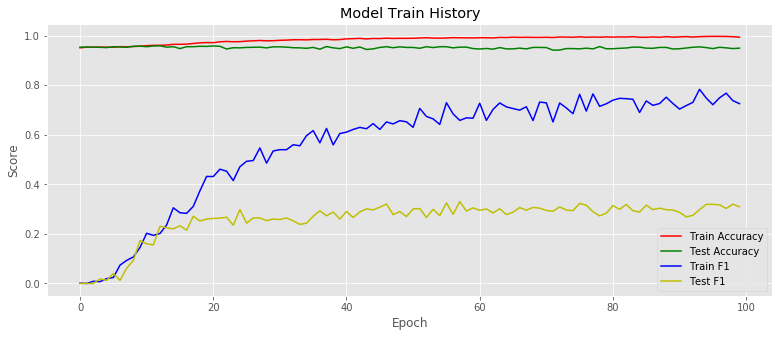

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,94.93,44.93,38.75,41.61,69.48,0.05,0.68,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1598   38]
 [  49   31]]


---> Splitting data (train/test)...
---> Training the `microwave` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.0783 - accuracy: 0.9825 - f1: 0.9902 - val_loss: 0.0742 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 2/100
5145/5145 - 4s - loss: 0.0528 - accuracy: 0.9862 - f1: 0.9929 - val_loss: 0.0497 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 3/100
5145/5145 - 4s - loss: 0.0503 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.0844 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 4/100
5145/5145 - 4s - loss: 0.0580 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.0974 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 5/100
5145/5145 - 4s - loss: 0.0471 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.0531 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 6/100
5145/5145 - 4s - loss: 0.0441 - accuracy: 0.9862 - f1: 0.9929 - val_loss: 0.0662 - val_accuracy: 0.9860 - val_f1: 0.9929
E

Epoch 61/100
5145/5145 - 4s - loss: 0.0155 - accuracy: 0.9932 - f1: 0.9965 - val_loss: 0.1061 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 62/100
5145/5145 - 4s - loss: 0.0161 - accuracy: 0.9920 - f1: 0.9959 - val_loss: 0.0957 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 63/100
5145/5145 - 4s - loss: 0.0169 - accuracy: 0.9926 - f1: 0.9962 - val_loss: 0.1153 - val_accuracy: 0.9866 - val_f1: 0.9932
Epoch 64/100
5145/5145 - 4s - loss: 0.0148 - accuracy: 0.9934 - f1: 0.9966 - val_loss: 0.1234 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 65/100
5145/5145 - 4s - loss: 0.0159 - accuracy: 0.9916 - f1: 0.9957 - val_loss: 0.1155 - val_accuracy: 0.9825 - val_f1: 0.9911
Epoch 66/100
5145/5145 - 4s - loss: 0.0150 - accuracy: 0.9932 - f1: 0.9965 - val_loss: 0.1076 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 67/100
5145/5145 - 4s - loss: 0.0137 - accuracy: 0.9936 - f1: 0.9967 - val_loss: 0.1257 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 68/100
5145/5145 - 4s - loss: 0.0160 - accuracy: 0.9938 

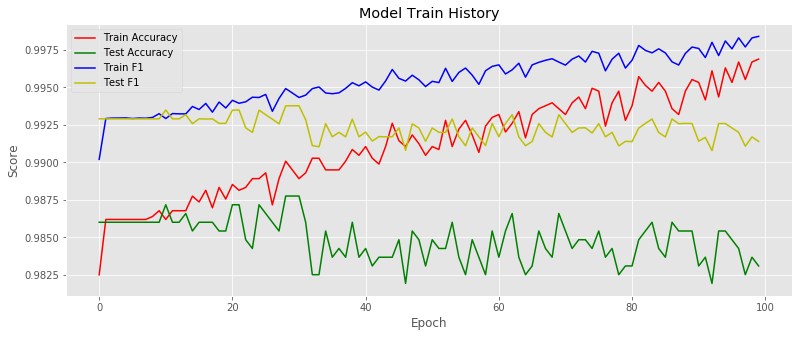

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,98.31,99.17,99.11,99.14,69.98,0.02,0.7,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[  10   14]
 [  15 1677]]



In [15]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-best.h5".format("gaf", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
    
    # Persisting model
    model.save("models/{}-{}-{}.h5".format("gaf", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

## Imagens RP

In [14]:
# IMPORTANTE NOTE (maybe TODO ?):
# ----------------------------------------------------------------
# From the aforementioned definitions, it becomes evident
# that the recurrence plot depends on three parameters, the delay
# τ , the embedding dimension D and the radius , to capture
# the correct dynamics of a system with noise.
# https://www.researchgate.net/publication/326290928_Optimising_Parameters_in_Recurrence_Quantification_Analysis_of_Smart_Energy_Systems
# https://oro.open.ac.uk/55774/1/RAE-arxiv.pdf
if not os.path.isfile( os.path.join(DATASET_PATH, "rp_images.npy") ):# or \
    #input("Já existe um arquivo processado. Deseja gerar as imagens novamente? S/N: ").upper() == "S":
    
    print("Generating RP images from data...")
    rp_pipeline = Pipeline([
         ('recurrenceplot', RecurrencePlot(
            dimension = 1,
            threshold = None,
            time_delay = 1,
            percentage = 10
        )),
        ('imageprocessing', ImageProcessing())
    ])
    series_images = rp_pipeline.fit_transform(mains_agg, imageprocessing__mode = "_")
    np.save(os.path.join(DATASET_PATH, "rp_images.npy"), series_images)
else:
    print("Loading RP images...")
    series_images = np.load(os.path.join(DATASET_PATH, "rp_images.npy"))

Loading RP images...


==================== AGGREGATED MAINS INFO ====================

Mean scaled matrix: -0.00000000


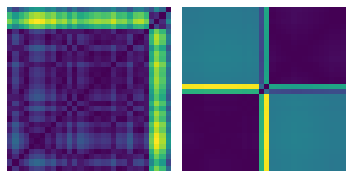

In [24]:
print("="*20, "AGGREGATED MAINS INFO", "="*20)

print()
print('Mean scaled matrix: {:.8f}'.format( np.mean(mains_agg) ))

idx0 = 0
idx1 = 88

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axes[0].imshow(series_images[idx0], origin="lower")
axes[0].axis('off');
axes[1].imshow(series_images[idx1], origin="lower");
axes[1].axis('off');
fig.tight_layout();

==================== MAINS 0 INFO ====================

Mean original matrix: 247.82319641


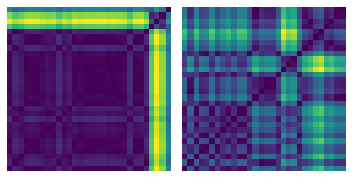

In [25]:
print("="*20, "MAINS {} INFO".format(mains_idx), "="*20)

print()
print('Mean original matrix: {:.8f}'.format( np.mean(mains[mains_idx,:,:]) ))

images = rp_pipeline.fit_transform( mains[mains_idx, :100, :] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
axes[0].imshow(images[idx0], origin="lower")
axes[0].axis('off');
axes[1].imshow(images[idx1], origin="lower");
axes[1].axis('off');
fig.tight_layout();

### Classificador Multilabel

---> Splitting data (train/test)...
---> Training the `RP-multilabel` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.1940 - accuracy: 0.9334 - f1: 0.9411 - val_loss: 0.1865 - val_accuracy: 0.9545 - val_f1: 0.9599
Epoch 2/100
5145/5145 - 4s - loss: 0.1370 - accuracy: 0.9512 - f1: 0.9575 - val_loss: 0.1475 - val_accuracy: 0.9550 - val_f1: 0.9605
Epoch 3/100
5145/5145 - 4s - loss: 0.1180 - accuracy: 0.9586 - f1: 0.9638 - val_loss: 0.1227 - val_accuracy: 0.9566 - val_f1: 0.9619
Epoch 4/100
5145/5145 - 4s - loss: 0.1111 - accuracy: 0.9586 - f1: 0.9638 - val_loss: 0.1350 - val_accuracy: 0.9558 - val_f1: 0.9612
Epoch 5/100
5145/5145 - 4s - loss: 0.1061 - accuracy: 0.9606 - f1: 0.9656 - val_loss: 0.1311 - val_accuracy: 0.9554 - val_f1: 0.9609
Epoch 6/100
5145/5145 - 5s - loss: 0.1019 - accuracy: 0.9622 - f1: 0.9670 - val_loss: 0.1271 - val_accuracy: 0.9531 - val_f1: 0.9590
Epoch 7/100
5145/5145 - 4s - loss: 0.0954 - accuracy: 0.9620 - f1: 0.9667 

Epoch 62/100
5145/5145 - 4s - loss: 0.0171 - accuracy: 0.9934 - f1: 0.9942 - val_loss: 0.3384 - val_accuracy: 0.9550 - val_f1: 0.9604
Epoch 63/100
5145/5145 - 4s - loss: 0.0157 - accuracy: 0.9934 - f1: 0.9942 - val_loss: 0.3754 - val_accuracy: 0.9571 - val_f1: 0.9621
Epoch 64/100
5145/5145 - 4s - loss: 0.0152 - accuracy: 0.9939 - f1: 0.9947 - val_loss: 0.3691 - val_accuracy: 0.9557 - val_f1: 0.9611
Epoch 65/100
5145/5145 - 4s - loss: 0.0164 - accuracy: 0.9936 - f1: 0.9944 - val_loss: 0.3870 - val_accuracy: 0.9549 - val_f1: 0.9601
Epoch 66/100
5145/5145 - 4s - loss: 0.0171 - accuracy: 0.9927 - f1: 0.9937 - val_loss: 0.3796 - val_accuracy: 0.9554 - val_f1: 0.9607
Epoch 67/100
5145/5145 - 4s - loss: 0.0154 - accuracy: 0.9939 - f1: 0.9947 - val_loss: 0.3817 - val_accuracy: 0.9564 - val_f1: 0.9616
Epoch 68/100
5145/5145 - 4s - loss: 0.0140 - accuracy: 0.9947 - f1: 0.9954 - val_loss: 0.4103 - val_accuracy: 0.9569 - val_f1: 0.9620
Epoch 69/100
5145/5145 - 4s - loss: 0.0136 - accuracy: 0.9943 

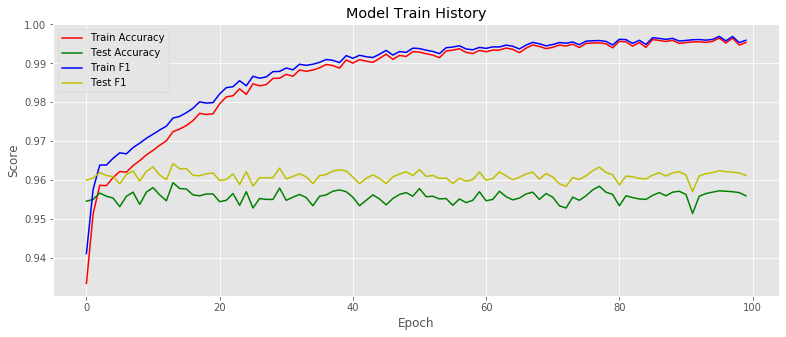

CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,97.14,98.09,98.56,98.33,94.29,0.03,0.94,255,1461
1,dishwasher,91.84,94.23,97.00,95.59,70.24,0.08,0.67,150,1566
2,washer dryer 1,95.98,31.25,17.54,22.47,60.20,0.04,0.58,1659,57
3,washer dryer 2,94.58,24.24,10.53,14.68,55.94,0.05,0.55,1640,76
4,microwave,98.43,98.77,99.64,99.20,64.99,0.02,0.61,27,1689



OVERALL AVERAGE PERFORMANCE:


,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
mean,95.59,69.32,64.65,66.05,69.13,0.04,0.67,746.2,969.8
max,98.43,98.77,99.64,99.20,94.29,0.08,0.94,1659.0,1689.0
min,91.84,24.24,10.53,14.68,55.94,0.02,0.55,27.0,57.0



CONFUSION MATRIX (OFF/ON), BY APPLIANCE:

 - refrigerator:
[[ 227   28]
 [  21 1440]]

 - dishwasher:
[[  57   93]
 [  47 1519]]

 - washer dryer 1:
[[1637   22]
 [  47   10]]

 - washer dryer 2:
[[1615   25]
 [  68    8]]

 - microwave:
[[   6   21]
 [   6 1683]]


In [26]:
print("---> Splitting data (train/test)...")
X_train, X_test, y_train, y_test = train_test_split(
    series_images, labels_binary,
    #stratify = labels_binary[:, i],
    random_state=SEED, test_size=TEST_SIZE#, shuffle=True
)

print("---> Training the `RP-multilabel` model...\n")

multilabel_rp_model = dcnn_multilabel()

callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
    ModelCheckpoint(
        filepath="models/{}-{}-best.h5".format("rp", "multilabel"), 
        monitor='val_f1', 
        save_best_only=True
    )
]

callback = multilabel_rp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose = 2, callbacks = callbacks_
)


# Persisting model
multilabel_rp_model.save("models/{}-{}.h5".format("rp", "multilabel"))

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multilabel_rp_model.predict(X_test).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### Classificadores Especialistas(Binários)

In [ ]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
    
    # Persisting model
    model.save("models/{}-{}-{}.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

#### Desblanceamento de Classes


---> Splitting data (train/test)...
---> Class weights: [3.37155963 0.5870607 ]
---> Training the `refrigerator` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.3801 - accuracy: 0.8515 - f1: 0.9186 - val_loss: 0.3047 - val_accuracy: 0.8520 - val_f1: 0.9188
Epoch 2/100
5145/5145 - 4s - loss: 0.2528 - accuracy: 0.8849 - f1: 0.9361 - val_loss: 0.2827 - val_accuracy: 0.9516 - val_f1: 0.9708
Epoch 3/100
5145/5145 - 4s - loss: 0.2010 - accuracy: 0.9454 - f1: 0.9688 - val_loss: 0.2225 - val_accuracy: 0.9639 - val_f1: 0.9784
Epoch 4/100
5145/5145 - 4s - loss: 0.1943 - accuracy: 0.9617 - f1: 0.9774 - val_loss: 0.1963 - val_accuracy: 0.9720 - val_f1: 0.9834
Epoch 5/100
5145/5145 - 4s - loss: 0.1829 - accuracy: 0.9687 - f1: 0.9816 - val_loss: 0.1780 - val_accuracy: 0.9749 - val_f1: 0.9852
Epoch 6/100
5145/5145 - 4s - loss: 0.1749 - accuracy: 0.9722 - f1: 0.9836 - val_loss: 0.1782 - val_accuracy: 0.9749 - val_f1: 0.9852
Epoch 7/100
5145/5145 - 4s - l

Epoch 61/100
5145/5145 - 4s - loss: 0.0189 - accuracy: 0.9948 - f1: 0.9969 - val_loss: 0.4040 - val_accuracy: 0.9685 - val_f1: 0.9810
Epoch 62/100
5145/5145 - 4s - loss: 0.0231 - accuracy: 0.9926 - f1: 0.9956 - val_loss: 0.3485 - val_accuracy: 0.9580 - val_f1: 0.9741
Epoch 63/100
5145/5145 - 4s - loss: 0.0189 - accuracy: 0.9951 - f1: 0.9971 - val_loss: 0.3982 - val_accuracy: 0.9650 - val_f1: 0.9788
Epoch 64/100
5145/5145 - 4s - loss: 0.0166 - accuracy: 0.9951 - f1: 0.9971 - val_loss: 0.3843 - val_accuracy: 0.9639 - val_f1: 0.9784
Epoch 65/100
5145/5145 - 4s - loss: 0.0231 - accuracy: 0.9924 - f1: 0.9955 - val_loss: 0.3502 - val_accuracy: 0.9627 - val_f1: 0.9776
Epoch 66/100
5145/5145 - 4s - loss: 0.0208 - accuracy: 0.9942 - f1: 0.9966 - val_loss: 0.3393 - val_accuracy: 0.9645 - val_f1: 0.9787
Epoch 67/100
5145/5145 - 4s - loss: 0.0249 - accuracy: 0.9928 - f1: 0.9957 - val_loss: 0.3730 - val_accuracy: 0.9586 - val_f1: 0.9750
Epoch 68/100
5145/5145 - 4s - loss: 0.0205 - accuracy: 0.9936 

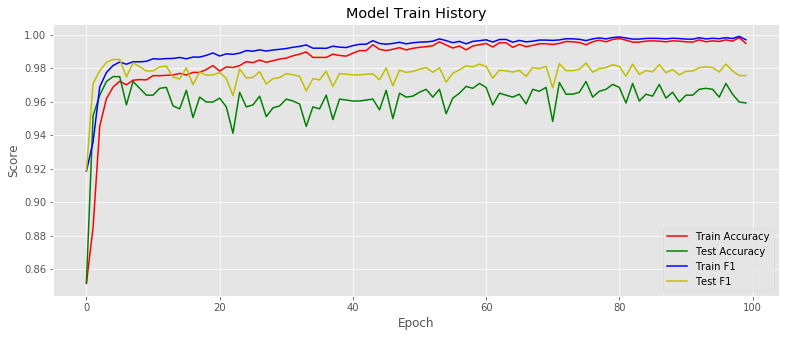

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,95.92,97.48,97.74,97.61,91.86,0.04,0.92,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 217   37]
 [  33 1429]]


---> Splitting data (train/test)...
---> Class weights: [6.57928389 0.54112326]
---> Training the `dishwasher` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 0.2639 - accuracy: 0.9211 - f1: 0.9578 - val_loss: 0.2195 - val_accuracy: 0.9242 - val_f1: 0.9601
Epoch 2/100
5145/5145 - 4s - loss: 0.1921 - accuracy: 0.9228 - f1: 0.9590 - val_loss: 0.2068 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 3/100
5145/5145 - 4s - loss: 0.1841 - accuracy: 0.9226 - f1: 0.9591 - val_loss: 0.2050 - val_accuracy: 0.9277 - val_f1: 0.9615
Epoch 4/100
5145/5145 - 4s - loss: 0.1791 - accuracy: 0.9242 - f1: 0.9599 - val_loss: 0.1869 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 5/100
5145/5145 - 4s - loss: 0.1745 - accuracy: 0.9242 - f1: 0.9600 - val_loss: 0.1798 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 6/100
5145/5145 - 4s - loss: 0.1760 - accuracy: 0.9248 - f1: 0.9603 - val_loss: 0.178

Epoch 61/100
5145/5145 - 4s - loss: 0.0241 - accuracy: 0.9909 - f1: 0.9949 - val_loss: 0.4690 - val_accuracy: 0.9219 - val_f1: 0.9572
Epoch 62/100
5145/5145 - 4s - loss: 0.0273 - accuracy: 0.9903 - f1: 0.9947 - val_loss: 0.4608 - val_accuracy: 0.9225 - val_f1: 0.9578
Epoch 63/100
5145/5145 - 4s - loss: 0.0275 - accuracy: 0.9893 - f1: 0.9940 - val_loss: 0.5702 - val_accuracy: 0.9237 - val_f1: 0.9587
Epoch 64/100
5145/5145 - 4s - loss: 0.0249 - accuracy: 0.9916 - f1: 0.9954 - val_loss: 0.4704 - val_accuracy: 0.9184 - val_f1: 0.9555
Epoch 65/100
5145/5145 - 4s - loss: 0.0201 - accuracy: 0.9938 - f1: 0.9966 - val_loss: 0.5190 - val_accuracy: 0.9149 - val_f1: 0.9535
Epoch 66/100
5145/5145 - 4s - loss: 0.0229 - accuracy: 0.9916 - f1: 0.9954 - val_loss: 0.5599 - val_accuracy: 0.9272 - val_f1: 0.9605
Epoch 67/100
5145/5145 - 4s - loss: 0.0216 - accuracy: 0.9946 - f1: 0.9969 - val_loss: 0.5089 - val_accuracy: 0.9219 - val_f1: 0.9575
Epoch 68/100
5145/5145 - 4s - loss: 0.0194 - accuracy: 0.9938 

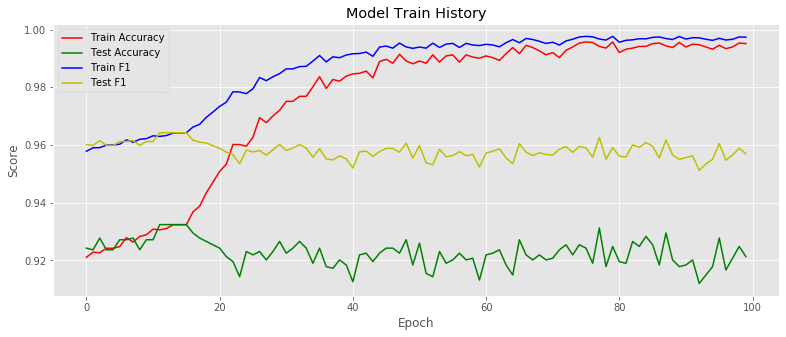

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,92.13,95.43,96.09,95.76,70.99,0.08,0.7,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  58   73]
 [  62 1523]]


---> Splitting data (train/test)...
---> Class weights: [ 0.51875378 13.83064516]
---> Training the `washer dryer 1` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.2002 - accuracy: 0.9613 - f1: 0.0000e+00 - val_loss: 0.1303 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 0.1138 - accuracy: 0.9638 - f1: 0.0041 - val_loss: 0.1499 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 0.1160 - accuracy: 0.9629 - f1: 0.0000e+00 - val_loss: 0.1252 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 0.1068 - accuracy: 0.9637 - f1: 0.0124 - val_loss: 0.1363 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 5/100
5145/5145 - 4s - loss: 0.1030 - accuracy: 0.9629 - f1: 0.0041 - val_loss: 0.1115 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 6/100
5145/5145 - 4s - loss: 0.0987 - accuracy: 0.964

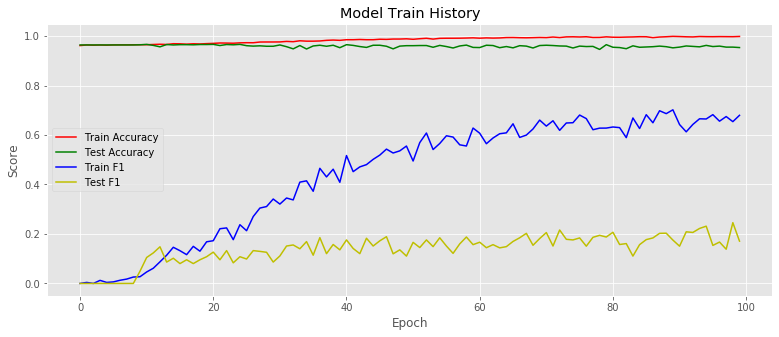

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,95.34,31.25,24.19,27.27,62.43,0.05,0.61,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1621   33]
 [  47   15]]


---> Splitting data (train/test)...
---> Class weights: [ 0.52457178 10.67427386]
---> Training the `washer dryer 2` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.1795 - accuracy: 0.9516 - f1: 0.0017 - val_loss: 0.3068 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 0.1429 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 0.1867 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 0.1363 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 0.1788 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 0.1321 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 0.1504 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 5/100
5145/5145 - 4s - loss: 0.1261 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 6/100
5145/5145 - 4s - loss: 0.1220 - acc

Epoch 60/100
5145/5145 - 4s - loss: 0.0173 - accuracy: 0.9932 - f1: 0.6822 - val_loss: 0.3281 - val_accuracy: 0.9446 - val_f1: 0.2833
Epoch 61/100
5145/5145 - 4s - loss: 0.0199 - accuracy: 0.9918 - f1: 0.7352 - val_loss: 0.4069 - val_accuracy: 0.9476 - val_f1: 0.2481
Epoch 62/100
5145/5145 - 4s - loss: 0.0158 - accuracy: 0.9940 - f1: 0.6699 - val_loss: 0.3939 - val_accuracy: 0.9493 - val_f1: 0.2500
Epoch 63/100
5145/5145 - 4s - loss: 0.0146 - accuracy: 0.9948 - f1: 0.7352 - val_loss: 0.3467 - val_accuracy: 0.9446 - val_f1: 0.3037
Epoch 64/100
5145/5145 - 4s - loss: 0.0162 - accuracy: 0.9936 - f1: 0.7563 - val_loss: 0.3721 - val_accuracy: 0.9441 - val_f1: 0.2951
Epoch 65/100
5145/5145 - 4s - loss: 0.0276 - accuracy: 0.9909 - f1: 0.6975 - val_loss: 0.3456 - val_accuracy: 0.9417 - val_f1: 0.2531
Epoch 66/100
5145/5145 - 4s - loss: 0.0198 - accuracy: 0.9918 - f1: 0.6865 - val_loss: 0.4208 - val_accuracy: 0.9476 - val_f1: 0.2414
Epoch 67/100
5145/5145 - 4s - loss: 0.0164 - accuracy: 0.9934 

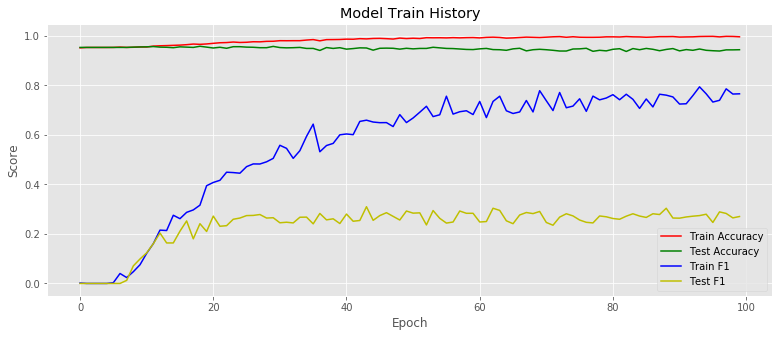

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,94.41,38.24,32.5,35.14,66.11,0.06,0.65,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1594   42]
 [  54   26]]


---> Splitting data (train/test)...
---> Class weights: [36.23239437  0.50699645]
---> Training the `microwave` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 0.0946 - accuracy: 0.9841 - f1: 0.9915 - val_loss: 0.0669 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 2/100
5145/5145 - 4s - loss: 0.0533 - accuracy: 0.9862 - f1: 0.9929 - val_loss: 0.0436 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 3/100
5145/5145 - 4s - loss: 0.0477 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.0806 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 4/100
5145/5145 - 4s - loss: 0.0502 - accuracy: 0.9860 - f1: 0.9929 - val_loss: 0.0435 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 5/100
5145/5145 - 4s - loss: 0.0414 - accuracy: 0.9864 - f1: 0.9931 - val_loss: 0.0435 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 6/100
5145/5145 - 4s - loss: 0.0424 - accuracy: 0.9856 - f1: 0.9926 - val_loss: 0.

Epoch 61/100
5145/5145 - 4s - loss: 0.0059 - accuracy: 0.9977 - f1: 0.9988 - val_loss: 0.0798 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 62/100
5145/5145 - 4s - loss: 0.0054 - accuracy: 0.9986 - f1: 0.9993 - val_loss: 0.0837 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 63/100
5145/5145 - 4s - loss: 0.0083 - accuracy: 0.9969 - f1: 0.9984 - val_loss: 0.0744 - val_accuracy: 0.9843 - val_f1: 0.9920
Epoch 64/100
5145/5145 - 4s - loss: 0.0047 - accuracy: 0.9990 - f1: 0.9995 - val_loss: 0.0913 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 65/100
5145/5145 - 4s - loss: 0.0046 - accuracy: 0.9986 - f1: 0.9993 - val_loss: 0.0895 - val_accuracy: 0.9825 - val_f1: 0.9912
Epoch 66/100
5145/5145 - 5s - loss: 0.0040 - accuracy: 0.9983 - f1: 0.9991 - val_loss: 0.0896 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 67/100
5145/5145 - 5s - loss: 0.0042 - accuracy: 0.9984 - f1: 0.9992 - val_loss: 0.0999 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 68/100
5145/5145 - 4s - loss: 0.0028 - accuracy: 0.9994 

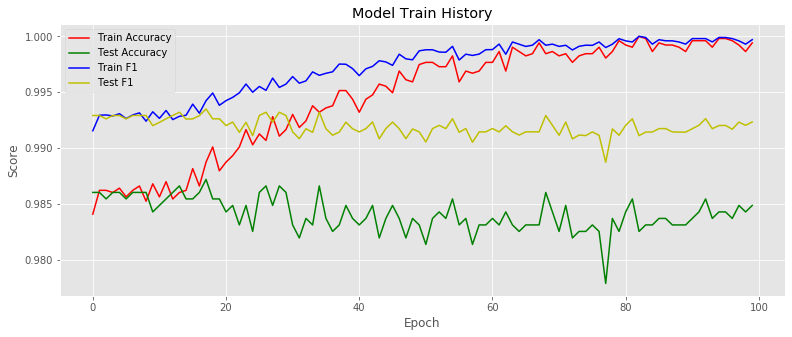

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,98.48,98.83,99.65,99.23,61.38,0.02,0.58,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[   4   20]
 [   6 1686]]



In [16]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-class_weights-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train),
        y_train
    )
    print("---> Class weights:", class_weights)
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_,
        class_weight = class_weights
    )
    
    # Persisting model
    model.save("models/{}-{}-{}-class_weights.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

#### Focal Loss

In [26]:
"""
Define our custom loss function.
"""
#from keras import backend as K
#import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed


# if __name__ == '__main__':

#     # Test serialization of nested functions
#     bin_inner = dill.loads(dill.dumps(binary_focal_loss(gamma=2., alpha=.25)))
#     print(bin_inner)

#     cat_inner = dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25)))
#     print(cat_inner)


---> Splitting data (train/test)...
---> Class weights: [3.37155963 0.5870607 ]
---> Training the `refrigerator` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 1.7537 - accuracy: 0.8187 - f1: 0.8766 - val_loss: 1.1464 - val_accuracy: 0.7826 - val_f1: 0.8547
Epoch 2/100
5145/5145 - 4s - loss: 0.9481 - accuracy: 0.8999 - f1: 0.9367 - val_loss: 0.9974 - val_accuracy: 0.8339 - val_f1: 0.8925
Epoch 3/100
5145/5145 - 4s - loss: 0.7197 - accuracy: 0.9487 - f1: 0.9692 - val_loss: 0.6410 - val_accuracy: 0.9499 - val_f1: 0.9697
Epoch 4/100
5145/5145 - 4s - loss: 0.6115 - accuracy: 0.9590 - f1: 0.9753 - val_loss: 0.6217 - val_accuracy: 0.9551 - val_f1: 0.9731
Epoch 5/100
5145/5145 - 4s - loss: 0.5383 - accuracy: 0.9668 - f1: 0.9803 - val_loss: 0.5729 - val_accuracy: 0.9580 - val_f1: 0.9747
Epoch 6/100
5145/5145 - 4s - loss: 0.5212 - accuracy: 0.9677 - f1: 0.9808 - val_loss: 0.6042 - val_accuracy: 0.9575 - val_f1: 0.9743
Epoch 7/100
5145/5145 - 4s - l

Epoch 61/100
5145/5145 - 4s - loss: 0.1120 - accuracy: 0.9866 - f1: 0.9919 - val_loss: 1.7954 - val_accuracy: 0.9610 - val_f1: 0.9766
Epoch 62/100
5145/5145 - 4s - loss: 0.1068 - accuracy: 0.9891 - f1: 0.9934 - val_loss: 1.7501 - val_accuracy: 0.9516 - val_f1: 0.9707
Epoch 63/100
5145/5145 - 4s - loss: 0.1363 - accuracy: 0.9841 - f1: 0.9903 - val_loss: 2.0381 - val_accuracy: 0.9580 - val_f1: 0.9747
Epoch 64/100
5145/5145 - 4s - loss: 0.1186 - accuracy: 0.9860 - f1: 0.9916 - val_loss: 1.5234 - val_accuracy: 0.9510 - val_f1: 0.9706
Epoch 65/100
5145/5145 - 4s - loss: 0.1076 - accuracy: 0.9868 - f1: 0.9921 - val_loss: 1.9878 - val_accuracy: 0.9580 - val_f1: 0.9749
Epoch 66/100
5145/5145 - 4s - loss: 0.1295 - accuracy: 0.9831 - f1: 0.9898 - val_loss: 2.4257 - val_accuracy: 0.9650 - val_f1: 0.9788
Epoch 67/100
5145/5145 - 4s - loss: 0.1799 - accuracy: 0.9845 - f1: 0.9905 - val_loss: 2.0791 - val_accuracy: 0.9604 - val_f1: 0.9761
Epoch 68/100
5145/5145 - 4s - loss: 0.2111 - accuracy: 0.9738 

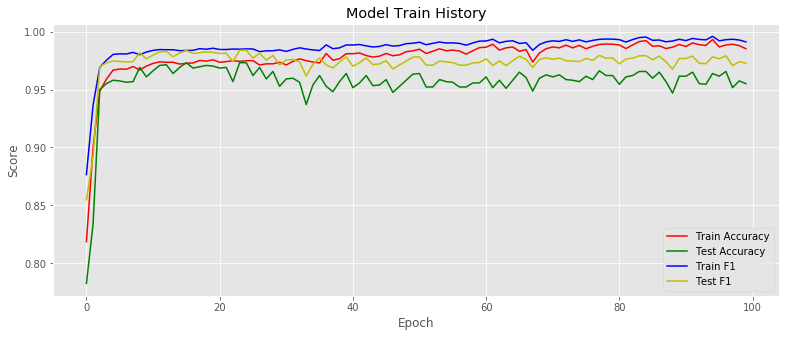

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,95.51,97.79,96.92,97.35,91.29,0.04,0.92,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 222   32]
 [  45 1417]]


---> Splitting data (train/test)...
---> Class weights: [6.57928389 0.54112326]
---> Training the `dishwasher` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 29.0387 - accuracy: 0.9201 - f1: 0.9570 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 2/100
5145/5145 - 4s - loss: 29.0286 - accuracy: 0.9240 - f1: 0.9597 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 3/100
5145/5145 - 4s - loss: 29.0286 - accuracy: 0.9240 - f1: 0.9599 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 4/100
5145/5145 - 4s - loss: 29.0611 - accuracy: 0.9240 - f1: 0.9600 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 5/100
5145/5145 - 4s - loss: 29.0449 - accuracy: 0.9240 - f1: 0.9600 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 6/100
5145/5145 - 4s - loss: 29.0449 - accuracy: 0.9240 - f1: 0.9600 - val_

Epoch 60/100
5145/5145 - 4s - loss: 29.0286 - accuracy: 0.9240 - f1: 0.9598 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 61/100
5145/5145 - 4s - loss: 29.0123 - accuracy: 0.9240 - f1: 0.9599 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 62/100
5145/5145 - 4s - loss: 29.0611 - accuracy: 0.9240 - f1: 0.9598 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 63/100
5145/5145 - 4s - loss: 29.0286 - accuracy: 0.9240 - f1: 0.9600 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 64/100
5145/5145 - 4s - loss: 29.0449 - accuracy: 0.9240 - f1: 0.9599 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 65/100
5145/5145 - 4s - loss: 29.0449 - accuracy: 0.9240 - f1: 0.9599 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 66/100
5145/5145 - 4s - loss: 29.0774 - accuracy: 0.9240 - f1: 0.9601 - val_loss: 29.1255 - val_accuracy: 0.9237 - val_f1: 0.9598
Epoch 67/100
5145/5145 - 4s - loss: 29.0286 - ac

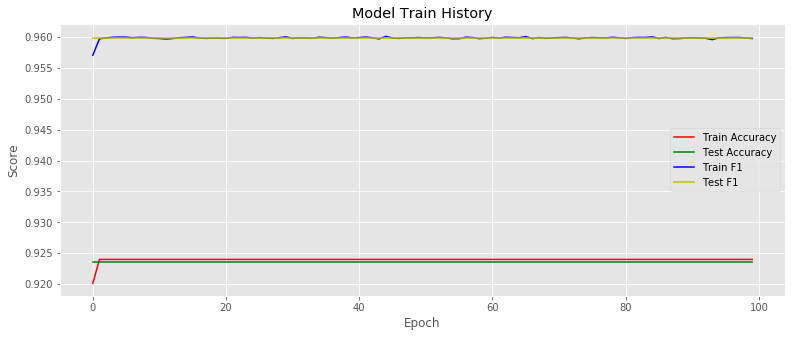

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,92.37,92.37,100.0,96.03,48.02,0.08,0.5,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[   0  131]
 [   0 1585]]


---> Splitting data (train/test)...
---> Class weights: [ 0.51875378 13.83064516]
---> Training the `washer dryer 1` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 4.6515 - accuracy: 0.9629 - f1: 0.0000e+00 - val_loss: 4.6307 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 4.6561 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 4.6307 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 4.6561 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 4.6307 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 4.6506 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 4.6307 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 5/100
5145/5145 - 4s - loss: 4.6616 - accuracy: 0.9638 - f1: 0.0000e+00 - val_loss: 4.6307 - val_accuracy: 0.9639 - val_f1: 0.0000e+00
Epoch 6/100
5145/5145 - 4s - loss: 4.6561 - acc

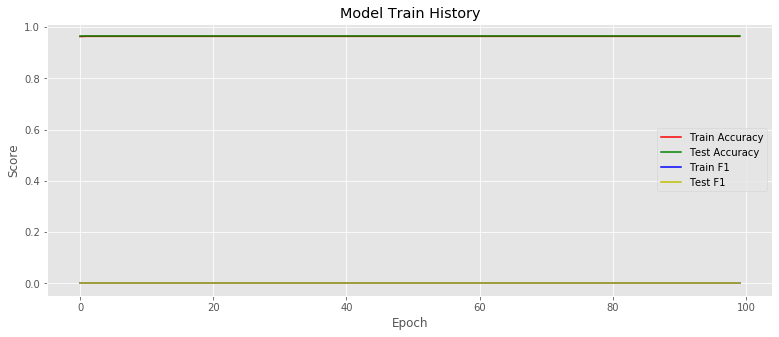

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,96.39,0.0,0.0,0.0,49.08,0.04,0.5,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1654    0]
 [  62    0]]


---> Splitting data (train/test)...
---> Class weights: [ 0.52457178 10.67427386]
---> Training the `washer dryer 2` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 5s - loss: 5.9784 - accuracy: 0.9510 - f1: 0.0014 - val_loss: 6.0114 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 2/100
5145/5145 - 4s - loss: 6.0235 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 6.0114 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 3/100
5145/5145 - 4s - loss: 6.0345 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 6.0114 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 4/100
5145/5145 - 4s - loss: 6.0345 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 6.0114 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 5/100
5145/5145 - 4s - loss: 6.0400 - accuracy: 0.9532 - f1: 0.0000e+00 - val_loss: 6.0114 - val_accuracy: 0.9534 - val_f1: 0.0000e+00
Epoch 6/100
5145/5145 - 4s - loss: 6.0400 - acc

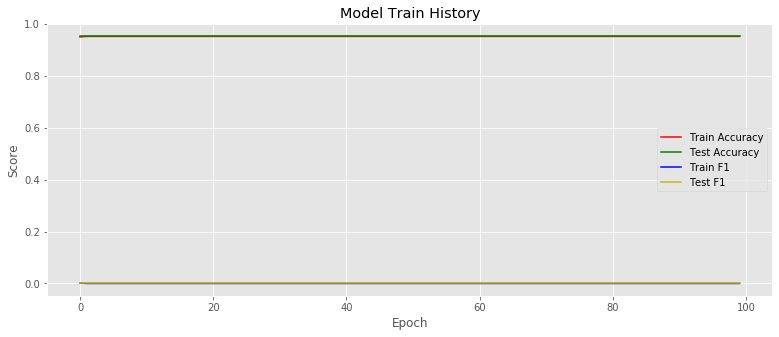

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,95.34,0.0,0.0,0.0,48.81,0.05,0.5,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1636    0]
 [  80    0]]


---> Splitting data (train/test)...
---> Class weights: [36.23239437  0.50699645]
---> Training the `microwave` model...

Train on 5145 samples, validate on 1716 samples
Epoch 1/100
5145/5145 - 6s - loss: 0.5190 - accuracy: 0.9821 - f1: 0.9898 - val_loss: 0.7517 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 2/100
5145/5145 - 4s - loss: 0.2673 - accuracy: 0.9862 - f1: 0.9929 - val_loss: 0.2368 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 3/100
5145/5145 - 4s - loss: 0.2314 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.3011 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 4/100
5145/5145 - 4s - loss: 0.2521 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.3248 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 5/100
5145/5145 - 4s - loss: 0.2243 - accuracy: 0.9862 - f1: 0.9930 - val_loss: 0.2058 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 6/100
5145/5145 - 4s - loss: 0.1876 - accuracy: 0.9841 - f1: 0.9918 - val_loss: 0.

Epoch 61/100
5145/5145 - 4s - loss: 0.0269 - accuracy: 0.9969 - f1: 0.9984 - val_loss: 0.6397 - val_accuracy: 0.9779 - val_f1: 0.9887
Epoch 62/100
5145/5145 - 4s - loss: 0.0202 - accuracy: 0.9969 - f1: 0.9984 - val_loss: 0.9446 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 63/100
5145/5145 - 4s - loss: 0.0337 - accuracy: 0.9953 - f1: 0.9976 - val_loss: 0.5856 - val_accuracy: 0.9796 - val_f1: 0.9895
Epoch 64/100
5145/5145 - 4s - loss: 0.0366 - accuracy: 0.9944 - f1: 0.9971 - val_loss: 0.6983 - val_accuracy: 0.9802 - val_f1: 0.9899
Epoch 65/100
5145/5145 - 4s - loss: 0.0382 - accuracy: 0.9944 - f1: 0.9971 - val_loss: 0.5413 - val_accuracy: 0.9808 - val_f1: 0.9901
Epoch 66/100
5145/5145 - 4s - loss: 0.0195 - accuracy: 0.9969 - f1: 0.9984 - val_loss: 0.7127 - val_accuracy: 0.9825 - val_f1: 0.9911
Epoch 67/100
5145/5145 - 4s - loss: 0.0332 - accuracy: 0.9938 - f1: 0.9968 - val_loss: 0.6880 - val_accuracy: 0.9808 - val_f1: 0.9902
Epoch 68/100
5145/5145 - 4s - loss: 0.0585 - accuracy: 0.9922 

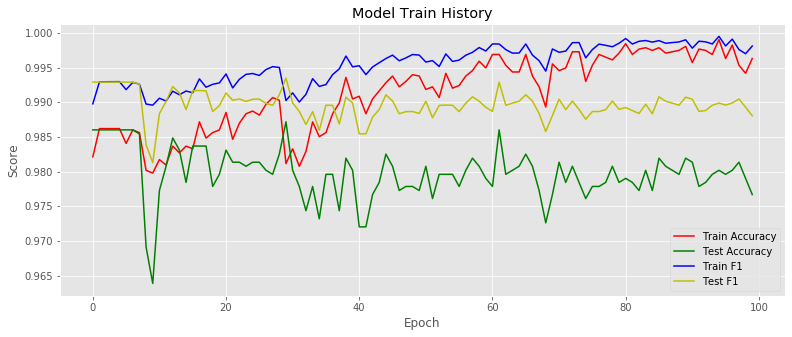

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,97.67,99.11,98.52,98.81,64.92,0.02,0.68,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[   9   15]
 [  25 1667]]



In [27]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# def focal_loss(y_true, y_pred, gamma = 2.0, alpha = 0.25):
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#     return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-focal_loss-class_weights-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )

    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train),
        y_train
    )
    print("---> Class weights:", class_weights)
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance(loss_function = binary_focal_loss(alpha=.25, gamma=2))
    
    # Calibrating model..
    callback = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_,
        class_weight = class_weights
    )
    
    # Persisting model
    model.save("models/{}-{}-{}-focal_loss-class_weights.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

#### Training Set Oversampling

In [28]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [29]:
# print("Original shape:", X_train.shape)
# print("Reshaped:", X_train.reshape(X_train.shape[0], -1).shape)
# print("Reshaped to original:", X_train.reshape(X_train.shape[0], -1).reshape(X_train.shape).shape)
# print("---")
# from collections import Counter
# print("Original distribution (training set):", Counter(y_train[:, 1]))
# print("---")
# from imblearn.over_sampling import RandomOverSampler
# X_resampled, y_resampled = RandomOverSampler().fit_resample(
#     X_train.reshape(X_train.shape[0], -1),
#     y_train[:, 1]
# )

# print("New distribution (training set):", Counter(y_resampled))


---> Splitting data (train/test)...
---> Training the `refrigerator` model...

Train on 8764 samples, validate on 1716 samples
Epoch 1/100
8764/8764 - 8s - loss: 0.4076 - accuracy: 0.8363 - f1: 0.8247 - val_loss: 0.3455 - val_accuracy: 0.8392 - val_f1: 0.8966
Epoch 2/100
8764/8764 - 7s - loss: 0.2173 - accuracy: 0.9127 - f1: 0.9135 - val_loss: 0.2226 - val_accuracy: 0.9470 - val_f1: 0.9679
Epoch 3/100
8764/8764 - 7s - loss: 0.1765 - accuracy: 0.9263 - f1: 0.9287 - val_loss: 0.1811 - val_accuracy: 0.9615 - val_f1: 0.9770
Epoch 4/100
8764/8764 - 7s - loss: 0.1478 - accuracy: 0.9375 - f1: 0.9386 - val_loss: 0.2133 - val_accuracy: 0.9225 - val_f1: 0.9527
Epoch 5/100
8764/8764 - 7s - loss: 0.1302 - accuracy: 0.9432 - f1: 0.9437 - val_loss: 0.1497 - val_accuracy: 0.9610 - val_f1: 0.9766
Epoch 6/100
8764/8764 - 7s - loss: 0.1112 - accuracy: 0.9501 - f1: 0.9502 - val_loss: 0.1682 - val_accuracy: 0.9545 - val_f1: 0.9728
Epoch 7/100
8764/8764 - 7s - loss: 0.1061 - accuracy: 0.9547 - f1: 0.9541 

Epoch 62/100
8764/8764 - 7s - loss: 0.0131 - accuracy: 0.9959 - f1: 0.9957 - val_loss: 0.3474 - val_accuracy: 0.9639 - val_f1: 0.9783
Epoch 63/100
8764/8764 - 7s - loss: 0.0098 - accuracy: 0.9975 - f1: 0.9975 - val_loss: 0.4052 - val_accuracy: 0.9668 - val_f1: 0.9800
Epoch 64/100
8764/8764 - 7s - loss: 0.0082 - accuracy: 0.9985 - f1: 0.9985 - val_loss: 0.3688 - val_accuracy: 0.9621 - val_f1: 0.9771
Epoch 65/100
8764/8764 - 7s - loss: 0.0098 - accuracy: 0.9975 - f1: 0.9973 - val_loss: 0.4193 - val_accuracy: 0.9668 - val_f1: 0.9800
Epoch 66/100
8764/8764 - 7s - loss: 0.0107 - accuracy: 0.9970 - f1: 0.9971 - val_loss: 0.4048 - val_accuracy: 0.9650 - val_f1: 0.9789
Epoch 67/100
8764/8764 - 7s - loss: 0.0060 - accuracy: 0.9985 - f1: 0.9986 - val_loss: 0.3998 - val_accuracy: 0.9650 - val_f1: 0.9787
Epoch 68/100
8764/8764 - 7s - loss: 0.0100 - accuracy: 0.9975 - f1: 0.9973 - val_loss: 0.4021 - val_accuracy: 0.9656 - val_f1: 0.9793
Epoch 69/100
8764/8764 - 7s - loss: 0.0113 - accuracy: 0.9974 

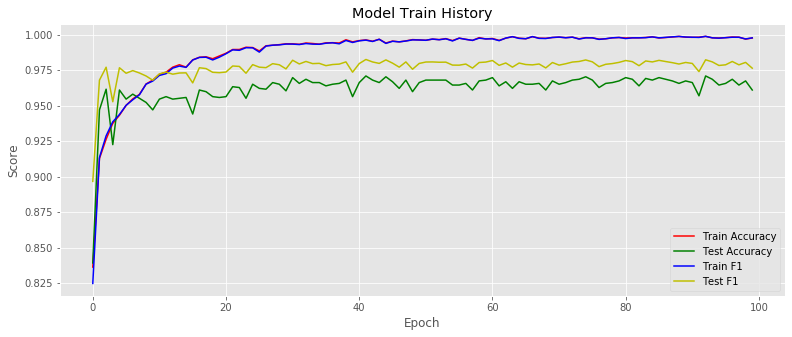

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,96.1,97.87,97.54,97.7,92.32,0.04,0.93,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 223   31]
 [  36 1426]]


---> Splitting data (train/test)...
---> Training the `dishwasher` model...

Train on 9508 samples, validate on 1716 samples
Epoch 1/100
9508/9508 - 10s - loss: 0.3947 - accuracy: 0.8247 - f1: 0.7968 - val_loss: 0.3691 - val_accuracy: 0.7990 - val_f1: 0.8767
Epoch 2/100
9508/9508 - 8s - loss: 0.2965 - accuracy: 0.8812 - f1: 0.8711 - val_loss: 0.3477 - val_accuracy: 0.8164 - val_f1: 0.8891
Epoch 3/100
9508/9508 - 8s - loss: 0.2508 - accuracy: 0.9026 - f1: 0.8923 - val_loss: 0.3026 - val_accuracy: 0.8415 - val_f1: 0.9052
Epoch 4/100
9508/9508 - 8s - loss: 0.2170 - accuracy: 0.9185 - f1: 0.9119 - val_loss: 0.2541 - val_accuracy: 0.8531 - val_f1: 0.9137
Epoch 5/100
9508/9508 - 8s - loss: 0.1892 - accuracy: 0.9256 - f1: 0.9196 - val_loss: 0.2726 - val_accuracy: 0.8613 - val_f1: 0.9190
Epoch 6/100
9508/9508 - 8s - loss: 0.1532 - accuracy: 0.9428 - f1: 0.9390 - val_loss: 0.3181 - val_accuracy: 0.8823 - val_f1: 0.9331
E

Epoch 61/100
9508/9508 - 8s - loss: 0.0111 - accuracy: 0.9960 - f1: 0.9946 - val_loss: 0.8275 - val_accuracy: 0.9155 - val_f1: 0.9536
Epoch 62/100
9508/9508 - 8s - loss: 0.0295 - accuracy: 0.9917 - f1: 0.9913 - val_loss: 0.7760 - val_accuracy: 0.9038 - val_f1: 0.9469
Epoch 63/100
9508/9508 - 7s - loss: 0.0101 - accuracy: 0.9965 - f1: 0.9964 - val_loss: 0.8781 - val_accuracy: 0.9120 - val_f1: 0.9519
Epoch 64/100
9508/9508 - 8s - loss: 0.0070 - accuracy: 0.9974 - f1: 0.9974 - val_loss: 0.8854 - val_accuracy: 0.9108 - val_f1: 0.9513
Epoch 65/100
9508/9508 - 8s - loss: 0.0082 - accuracy: 0.9976 - f1: 0.9976 - val_loss: 0.8636 - val_accuracy: 0.9167 - val_f1: 0.9543
Epoch 66/100
9508/9508 - 8s - loss: 0.0072 - accuracy: 0.9978 - f1: 0.9977 - val_loss: 0.8820 - val_accuracy: 0.9132 - val_f1: 0.9525
Epoch 67/100
9508/9508 - 8s - loss: 0.0108 - accuracy: 0.9967 - f1: 0.9932 - val_loss: 0.7242 - val_accuracy: 0.9132 - val_f1: 0.9526
Epoch 68/100
9508/9508 - 8s - loss: 0.0119 - accuracy: 0.9961 

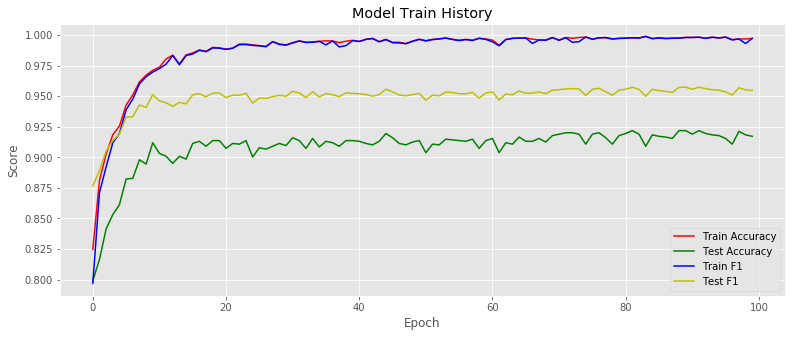

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,91.72,95.01,96.09,95.55,68.67,0.08,0.68,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  51   80]
 [  62 1523]]


---> Splitting data (train/test)...
---> Training the `washer dryer 1` model...

Train on 9918 samples, validate on 1716 samples
Epoch 1/100
9918/9918 - 11s - loss: 0.3359 - accuracy: 0.8589 - f1: 0.8562 - val_loss: 0.3235 - val_accuracy: 0.8357 - val_f1: 0.2511
Epoch 2/100
9918/9918 - 8s - loss: 0.2120 - accuracy: 0.9240 - f1: 0.9252 - val_loss: 0.2466 - val_accuracy: 0.8654 - val_f1: 0.2753
Epoch 3/100
9918/9918 - 8s - loss: 0.1633 - accuracy: 0.9410 - f1: 0.9417 - val_loss: 0.2738 - val_accuracy: 0.8753 - val_f1: 0.2623
Epoch 4/100
9918/9918 - 8s - loss: 0.1305 - accuracy: 0.9575 - f1: 0.9568 - val_loss: 0.1716 - val_accuracy: 0.9248 - val_f1: 0.2883
Epoch 5/100
9918/9918 - 8s - loss: 0.1115 - accuracy: 0.9628 - f1: 0.9623 - val_loss: 0.1858 - val_accuracy: 0.9190 - val_f1: 0.2366
Epoch 6/100
9918/9918 - 8s - loss: 0.0964 - accuracy: 0.9690 - f1: 0.9687 - val_loss: 0.1810 - val_accuracy: 0.9266 - val_f1: 0.2642

Epoch 61/100
9918/9918 - 8s - loss: 0.0011 - accuracy: 0.9996 - f1: 0.9996 - val_loss: 0.5056 - val_accuracy: 0.9610 - val_f1: 0.2531
Epoch 62/100
9918/9918 - 8s - loss: 0.0025 - accuracy: 0.9992 - f1: 0.9992 - val_loss: 0.4295 - val_accuracy: 0.9592 - val_f1: 0.2359
Epoch 63/100
9918/9918 - 8s - loss: 0.0019 - accuracy: 0.9992 - f1: 0.9992 - val_loss: 0.4783 - val_accuracy: 0.9592 - val_f1: 0.1938
Epoch 64/100
9918/9918 - 8s - loss: 0.0027 - accuracy: 0.9992 - f1: 0.9992 - val_loss: 0.4948 - val_accuracy: 0.9650 - val_f1: 0.2346
Epoch 65/100
9918/9918 - 8s - loss: 0.0012 - accuracy: 0.9995 - f1: 0.9995 - val_loss: 0.4887 - val_accuracy: 0.9639 - val_f1: 0.2543
Epoch 66/100
9918/9918 - 8s - loss: 0.0052 - accuracy: 0.9982 - f1: 0.9980 - val_loss: 0.4706 - val_accuracy: 0.9627 - val_f1: 0.2685
Epoch 67/100
9918/9918 - 8s - loss: 0.0025 - accuracy: 0.9992 - f1: 0.9991 - val_loss: 0.4236 - val_accuracy: 0.9580 - val_f1: 0.2160
Epoch 68/100
9918/9918 - 8s - loss: 6.5482e-04 - accuracy: 0.9

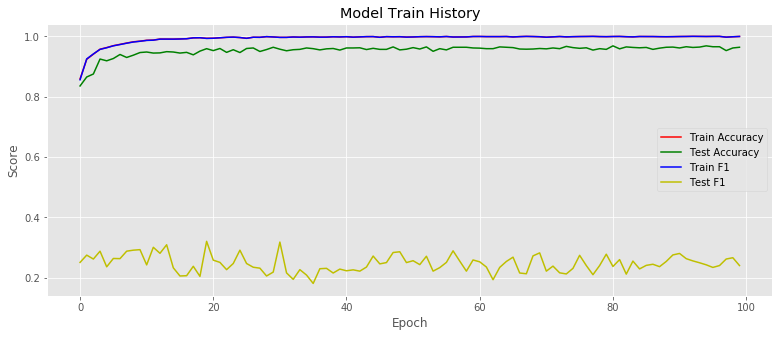

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,96.39,50.0,29.03,36.73,67.44,0.04,0.64,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1636   18]
 [  44   18]]


---> Splitting data (train/test)...
---> Training the `washer dryer 2` model...

Train on 9808 samples, validate on 1716 samples
Epoch 1/100
9808/9808 - 10s - loss: 0.3589 - accuracy: 0.8495 - f1: 0.8533 - val_loss: 0.3282 - val_accuracy: 0.8083 - val_f1: 0.2810
Epoch 2/100
9808/9808 - 8s - loss: 0.2495 - accuracy: 0.9063 - f1: 0.9107 - val_loss: 0.2395 - val_accuracy: 0.8467 - val_f1: 0.2711
Epoch 3/100
9808/9808 - 8s - loss: 0.1992 - accuracy: 0.9269 - f1: 0.9291 - val_loss: 0.2522 - val_accuracy: 0.8631 - val_f1: 0.2948
Epoch 4/100
9808/9808 - 8s - loss: 0.1631 - accuracy: 0.9406 - f1: 0.9416 - val_loss: 0.2670 - val_accuracy: 0.8800 - val_f1: 0.2985
Epoch 5/100
9808/9808 - 8s - loss: 0.1297 - accuracy: 0.9540 - f1: 0.9539 - val_loss: 0.2555 - val_accuracy: 0.8887 - val_f1: 0.2855
Epoch 6/100
9808/9808 - 8s - loss: 0.1077 - accuracy: 0.9626 - f1: 0.9625 - val_loss: 0.2652 - val_accuracy: 0.9097 - val_f1: 0.

Epoch 61/100
9808/9808 - 8s - loss: 0.0079 - accuracy: 0.9976 - f1: 0.9975 - val_loss: 0.7159 - val_accuracy: 0.9382 - val_f1: 0.2519
Epoch 62/100
9808/9808 - 8s - loss: 0.0086 - accuracy: 0.9971 - f1: 0.9969 - val_loss: 0.7670 - val_accuracy: 0.9371 - val_f1: 0.2849
Epoch 63/100
9808/9808 - 8s - loss: 0.0073 - accuracy: 0.9978 - f1: 0.9976 - val_loss: 0.6980 - val_accuracy: 0.9452 - val_f1: 0.2877
Epoch 64/100
9808/9808 - 8s - loss: 0.0045 - accuracy: 0.9986 - f1: 0.9985 - val_loss: 0.7389 - val_accuracy: 0.9411 - val_f1: 0.2679
Epoch 65/100
9808/9808 - 8s - loss: 0.0026 - accuracy: 0.9992 - f1: 0.9993 - val_loss: 0.9207 - val_accuracy: 0.9435 - val_f1: 0.2377
Epoch 66/100
9808/9808 - 8s - loss: 0.0080 - accuracy: 0.9975 - f1: 0.9974 - val_loss: 0.7119 - val_accuracy: 0.9406 - val_f1: 0.2772
Epoch 67/100
9808/9808 - 8s - loss: 0.0040 - accuracy: 0.9992 - f1: 0.9991 - val_loss: 0.8171 - val_accuracy: 0.9446 - val_f1: 0.2630
Epoch 68/100
9808/9808 - 8s - loss: 0.0050 - accuracy: 0.9987 

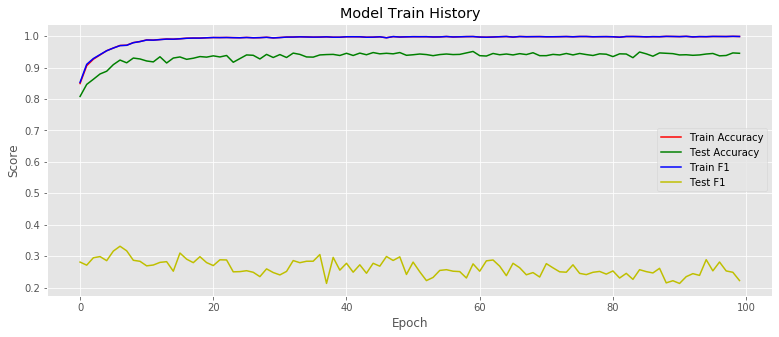

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,94.58,38.98,28.75,33.09,65.13,0.05,0.63,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1600   36]
 [  57   23]]


---> Splitting data (train/test)...
---> Training the `microwave` model...

Train on 10148 samples, validate on 1716 samples
Epoch 1/100
10148/10148 - 10s - loss: 0.2318 - accuracy: 0.9170 - f1: 0.9136 - val_loss: 0.1120 - val_accuracy: 0.9435 - val_f1: 0.9703
Epoch 2/100
10148/10148 - 8s - loss: 0.0986 - accuracy: 0.9718 - f1: 0.9691 - val_loss: 0.1421 - val_accuracy: 0.9493 - val_f1: 0.9734
Epoch 3/100
10148/10148 - 8s - loss: 0.0773 - accuracy: 0.9776 - f1: 0.9768 - val_loss: 0.1338 - val_accuracy: 0.9557 - val_f1: 0.9769
Epoch 4/100
10148/10148 - 8s - loss: 0.0550 - accuracy: 0.9833 - f1: 0.9828 - val_loss: 0.0931 - val_accuracy: 0.9674 - val_f1: 0.9832
Epoch 5/100
10148/10148 - 8s - loss: 0.0520 - accuracy: 0.9866 - f1: 0.9862 - val_loss: 0.0989 - val_accuracy: 0.9720 - val_f1: 0.9856
Epoch 6/100
10148/10148 - 8s - loss: 0.0418 - accuracy: 0.9896 - f1: 0.9890 - val_loss: 0.0909 - val_accuracy: 0.9784 - va

Epoch 60/100
10148/10148 - 8s - loss: 3.5960e-04 - accuracy: 0.9999 - f1: 0.9967 - val_loss: 0.2241 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 61/100
10148/10148 - 8s - loss: 7.6204e-04 - accuracy: 0.9997 - f1: 0.9997 - val_loss: 0.2198 - val_accuracy: 0.9843 - val_f1: 0.9920
Epoch 62/100
10148/10148 - 8s - loss: 6.5738e-05 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2405 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 63/100
10148/10148 - 8s - loss: 3.1609e-04 - accuracy: 0.9998 - f1: 0.9997 - val_loss: 0.2455 - val_accuracy: 0.9831 - val_f1: 0.9914
Epoch 64/100
10148/10148 - 8s - loss: 8.2835e-04 - accuracy: 0.9998 - f1: 0.9988 - val_loss: 0.2782 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 65/100
10148/10148 - 8s - loss: 0.0059 - accuracy: 0.9984 - f1: 0.9983 - val_loss: 0.2213 - val_accuracy: 0.9819 - val_f1: 0.9908
Epoch 66/100
10148/10148 - 8s - loss: 0.0014 - accuracy: 0.9994 - f1: 0.9994 - val_loss: 0.2305 - val_accuracy: 0.9819 - val_f1: 0.9908
Epoch 67/100
10148/10148 - 8

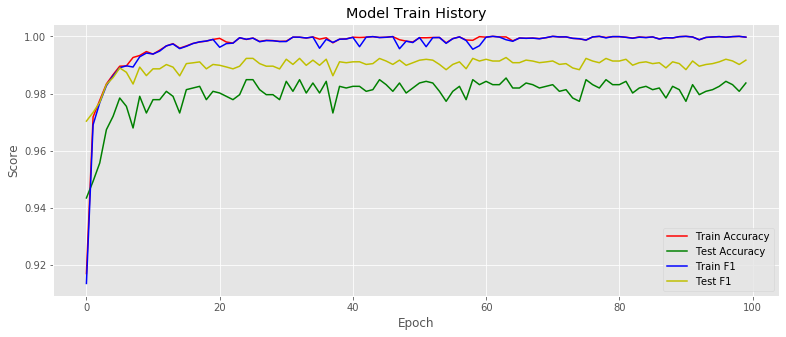

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,98.37,99.0,99.35,99.17,66.25,0.02,0.64,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[   7   17]
 [  11 1681]]



In [32]:

# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-oversampling_random-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
        
    del X_train_resampled
    del y_train_resampled
    
    # Persisting model
    model.save("models/{}-{}-{}-oversampling_random.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")


---> Splitting data (train/test)...
---> Training the `refrigerator` model...

Train on 8764 samples, validate on 1716 samples
Epoch 1/100
8764/8764 - 10s - loss: 0.4778 - accuracy: 0.7995 - f1: 0.7851 - val_loss: 0.5443 - val_accuracy: 0.7617 - val_f1: 0.8388
Epoch 2/100
8764/8764 - 7s - loss: 0.2385 - accuracy: 0.9048 - f1: 0.9038 - val_loss: 0.2264 - val_accuracy: 0.9441 - val_f1: 0.9662
Epoch 3/100
8764/8764 - 7s - loss: 0.1846 - accuracy: 0.9228 - f1: 0.9234 - val_loss: 0.1955 - val_accuracy: 0.9540 - val_f1: 0.9724
Epoch 4/100
8764/8764 - 7s - loss: 0.1598 - accuracy: 0.9337 - f1: 0.9339 - val_loss: 0.2357 - val_accuracy: 0.9423 - val_f1: 0.9654
Epoch 5/100
8764/8764 - 7s - loss: 0.1442 - accuracy: 0.9408 - f1: 0.9412 - val_loss: 0.1745 - val_accuracy: 0.9592 - val_f1: 0.9755
Epoch 6/100
8764/8764 - 7s - loss: 0.1333 - accuracy: 0.9476 - f1: 0.9476 - val_loss: 0.1686 - val_accuracy: 0.9709 - val_f1: 0.9826
Epoch 7/100
8764/8764 - 7s - loss: 0.1214 - accuracy: 0.9541 - f1: 0.9539

Epoch 62/100
8764/8764 - 7s - loss: 0.0188 - accuracy: 0.9935 - f1: 0.9933 - val_loss: 0.7009 - val_accuracy: 0.9691 - val_f1: 0.9813
Epoch 63/100
8764/8764 - 7s - loss: 0.0195 - accuracy: 0.9940 - f1: 0.9935 - val_loss: 0.5094 - val_accuracy: 0.9639 - val_f1: 0.9779
Epoch 64/100
8764/8764 - 7s - loss: 0.0246 - accuracy: 0.9927 - f1: 0.9925 - val_loss: 0.5958 - val_accuracy: 0.9639 - val_f1: 0.9779
Epoch 65/100
8764/8764 - 7s - loss: 0.0203 - accuracy: 0.9943 - f1: 0.9938 - val_loss: 0.6502 - val_accuracy: 0.9703 - val_f1: 0.9819
Epoch 66/100
8764/8764 - 7s - loss: 0.0189 - accuracy: 0.9946 - f1: 0.9944 - val_loss: 0.5229 - val_accuracy: 0.9662 - val_f1: 0.9793
Epoch 67/100
8764/8764 - 7s - loss: 0.0151 - accuracy: 0.9950 - f1: 0.9949 - val_loss: 0.6414 - val_accuracy: 0.9656 - val_f1: 0.9789
Epoch 68/100
8764/8764 - 7s - loss: 0.0169 - accuracy: 0.9944 - f1: 0.9944 - val_loss: 0.5826 - val_accuracy: 0.9604 - val_f1: 0.9758
Epoch 69/100
8764/8764 - 7s - loss: 0.0178 - accuracy: 0.9943 

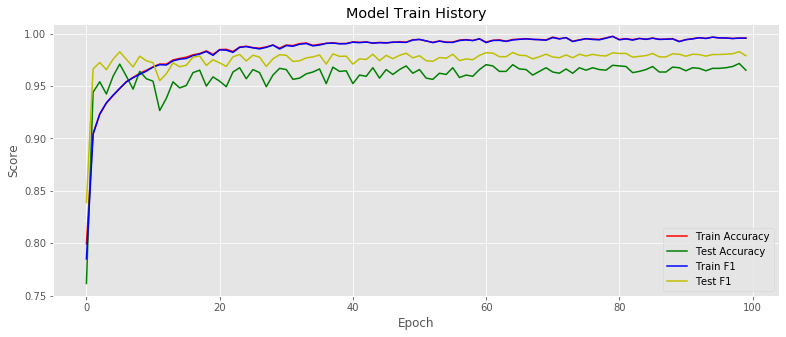

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,96.5,97.88,98.02,97.95,93.05,0.03,0.93,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 223   31]
 [  29 1433]]


---> Splitting data (train/test)...
---> Training the `dishwasher` model...

Train on 9508 samples, validate on 1716 samples
Epoch 1/100
9508/9508 - 9s - loss: 0.3583 - accuracy: 0.8522 - f1: 0.8369 - val_loss: 0.2948 - val_accuracy: 0.8339 - val_f1: 0.9008
Epoch 2/100
9508/9508 - 8s - loss: 0.2380 - accuracy: 0.9047 - f1: 0.8972 - val_loss: 0.2757 - val_accuracy: 0.8479 - val_f1: 0.9104
Epoch 3/100
9508/9508 - 8s - loss: 0.1839 - accuracy: 0.9250 - f1: 0.9200 - val_loss: 0.2921 - val_accuracy: 0.8450 - val_f1: 0.9083
Epoch 4/100
9508/9508 - 7s - loss: 0.1400 - accuracy: 0.9416 - f1: 0.9385 - val_loss: 0.2628 - val_accuracy: 0.8852 - val_f1: 0.9346
Epoch 5/100
9508/9508 - 7s - loss: 0.1170 - accuracy: 0.9562 - f1: 0.9547 - val_loss: 0.2307 - val_accuracy: 0.8969 - val_f1: 0.9416
Epoch 6/100
9508/9508 - 8s - loss: 0.0983 - accuracy: 0.9609 - f1: 0.9591 - val_loss: 0.2704 - val_accuracy: 0.8934 - val_f1: 0.9403
Ep

Epoch 61/100
9508/9508 - 8s - loss: 0.0098 - accuracy: 0.9972 - f1: 0.9970 - val_loss: 0.7787 - val_accuracy: 0.9260 - val_f1: 0.9602
Epoch 62/100
9508/9508 - 7s - loss: 0.0063 - accuracy: 0.9978 - f1: 0.9976 - val_loss: 0.8472 - val_accuracy: 0.9184 - val_f1: 0.9555
Epoch 63/100
9508/9508 - 8s - loss: 0.0076 - accuracy: 0.9974 - f1: 0.9973 - val_loss: 0.7745 - val_accuracy: 0.9091 - val_f1: 0.9499
Epoch 64/100
9508/9508 - 8s - loss: 0.0090 - accuracy: 0.9980 - f1: 0.9980 - val_loss: 0.6703 - val_accuracy: 0.9085 - val_f1: 0.9497
Epoch 65/100
9508/9508 - 8s - loss: 0.0131 - accuracy: 0.9968 - f1: 0.9968 - val_loss: 0.6749 - val_accuracy: 0.9056 - val_f1: 0.9480
Epoch 66/100
9508/9508 - 8s - loss: 0.0062 - accuracy: 0.9986 - f1: 0.9986 - val_loss: 0.8373 - val_accuracy: 0.9254 - val_f1: 0.9596
Epoch 67/100
9508/9508 - 7s - loss: 0.0070 - accuracy: 0.9979 - f1: 0.9945 - val_loss: 0.8581 - val_accuracy: 0.9184 - val_f1: 0.9555
Epoch 68/100
9508/9508 - 7s - loss: 0.0107 - accuracy: 0.9968 

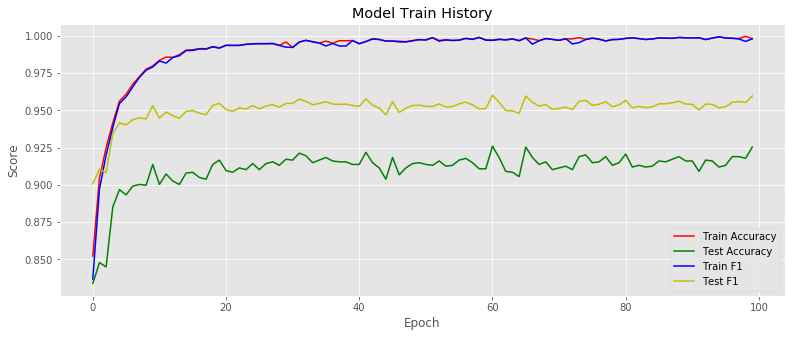

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,92.54,95.0,97.03,96.0,69.93,0.07,0.68,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  50   81]
 [  47 1538]]


---> Splitting data (train/test)...
---> Training the `washer dryer 1` model...

Train on 9918 samples, validate on 1716 samples
Epoch 1/100
9918/9918 - 9s - loss: 0.3031 - accuracy: 0.8803 - f1: 0.8809 - val_loss: 0.2924 - val_accuracy: 0.8467 - val_f1: 0.2456
Epoch 2/100
9918/9918 - 8s - loss: 0.2003 - accuracy: 0.9266 - f1: 0.9271 - val_loss: 0.2562 - val_accuracy: 0.8642 - val_f1: 0.2542
Epoch 3/100
9918/9918 - 8s - loss: 0.1607 - accuracy: 0.9426 - f1: 0.9426 - val_loss: 0.2143 - val_accuracy: 0.8887 - val_f1: 0.2744
Epoch 4/100
9918/9918 - 8s - loss: 0.1282 - accuracy: 0.9540 - f1: 0.9533 - val_loss: 0.1894 - val_accuracy: 0.9050 - val_f1: 0.1839
Epoch 5/100
9918/9918 - 8s - loss: 0.1068 - accuracy: 0.9621 - f1: 0.9619 - val_loss: 0.2006 - val_accuracy: 0.9225 - val_f1: 0.1601
Epoch 6/100
9918/9918 - 8s - loss: 0.0932 - accuracy: 0.9686 - f1: 0.9677 - val_loss: 0.2172 - val_accuracy: 0.9126 - val_f1: 0.1350


Epoch 61/100
9918/9918 - 8s - loss: 0.0046 - accuracy: 0.9989 - f1: 0.9989 - val_loss: 0.3860 - val_accuracy: 0.9510 - val_f1: 0.2512
Epoch 62/100
9918/9918 - 8s - loss: 0.0036 - accuracy: 0.9992 - f1: 0.9993 - val_loss: 0.5104 - val_accuracy: 0.9493 - val_f1: 0.2068
Epoch 63/100
9918/9918 - 8s - loss: 0.0012 - accuracy: 0.9998 - f1: 0.9998 - val_loss: 0.4944 - val_accuracy: 0.9493 - val_f1: 0.2340
Epoch 64/100
9918/9918 - 8s - loss: 3.5607e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.5862 - val_accuracy: 0.9528 - val_f1: 0.1704
Epoch 65/100
9918/9918 - 8s - loss: 0.0107 - accuracy: 0.9974 - f1: 0.9972 - val_loss: 0.4978 - val_accuracy: 0.9417 - val_f1: 0.2895
Epoch 66/100
9918/9918 - 8s - loss: 0.0067 - accuracy: 0.9976 - f1: 0.9974 - val_loss: 0.4502 - val_accuracy: 0.9493 - val_f1: 0.2593
Epoch 67/100
9918/9918 - 8s - loss: 0.0023 - accuracy: 0.9994 - f1: 0.9994 - val_loss: 0.4839 - val_accuracy: 0.9423 - val_f1: 0.2370
Epoch 68/100
9918/9918 - 8s - loss: 0.0022 - accuracy: 0.9

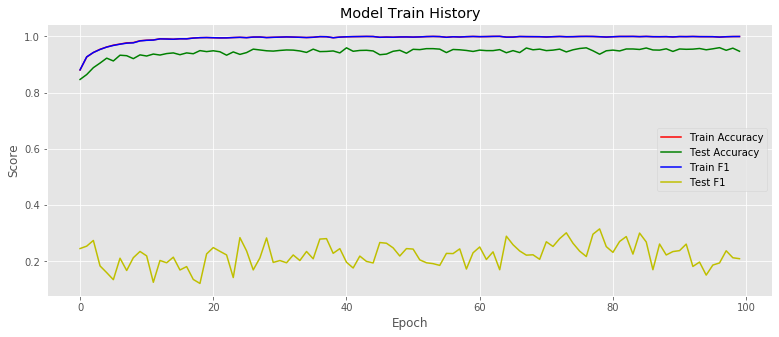

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,94.7,28.99,32.26,30.53,63.89,0.05,0.65,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1605   49]
 [  42   20]]


---> Splitting data (train/test)...
---> Training the `washer dryer 2` model...

Train on 9808 samples, validate on 1716 samples
Epoch 1/100
9808/9808 - 9s - loss: 0.3836 - accuracy: 0.8435 - f1: 0.8464 - val_loss: 0.4154 - val_accuracy: 0.7751 - val_f1: 0.2498
Epoch 2/100
9808/9808 - 8s - loss: 0.2636 - accuracy: 0.9007 - f1: 0.9037 - val_loss: 0.2487 - val_accuracy: 0.8584 - val_f1: 0.3099
Epoch 3/100
9808/9808 - 8s - loss: 0.2157 - accuracy: 0.9231 - f1: 0.9243 - val_loss: 0.2565 - val_accuracy: 0.8555 - val_f1: 0.2801
Epoch 4/100
9808/9808 - 8s - loss: 0.1855 - accuracy: 0.9353 - f1: 0.9366 - val_loss: 0.2477 - val_accuracy: 0.8770 - val_f1: 0.2917
Epoch 5/100
9808/9808 - 8s - loss: 0.1551 - accuracy: 0.9462 - f1: 0.9459 - val_loss: 0.2624 - val_accuracy: 0.8800 - val_f1: 0.2844
Epoch 6/100
9808/9808 - 8s - loss: 0.1264 - accuracy: 0.9566 - f1: 0.9561 - val_loss: 0.2428 - val_accuracy: 0.8840 - val_f1: 0.2

Epoch 61/100
9808/9808 - 8s - loss: 0.0058 - accuracy: 0.9983 - f1: 0.9982 - val_loss: 0.5543 - val_accuracy: 0.9417 - val_f1: 0.2747
Epoch 62/100
9808/9808 - 8s - loss: 0.0056 - accuracy: 0.9979 - f1: 0.9977 - val_loss: 0.7292 - val_accuracy: 0.9336 - val_f1: 0.2700
Epoch 63/100
9808/9808 - 8s - loss: 0.0145 - accuracy: 0.9961 - f1: 0.9961 - val_loss: 0.6216 - val_accuracy: 0.9394 - val_f1: 0.2741
Epoch 64/100
9808/9808 - 8s - loss: 0.0039 - accuracy: 0.9987 - f1: 0.9987 - val_loss: 0.6813 - val_accuracy: 0.9307 - val_f1: 0.2835
Epoch 65/100
9808/9808 - 8s - loss: 0.0027 - accuracy: 0.9989 - f1: 0.9990 - val_loss: 0.7274 - val_accuracy: 0.9423 - val_f1: 0.2650
Epoch 66/100
9808/9808 - 8s - loss: 0.0032 - accuracy: 0.9991 - f1: 0.9990 - val_loss: 0.7695 - val_accuracy: 0.9353 - val_f1: 0.2659
Epoch 67/100
9808/9808 - 8s - loss: 0.0033 - accuracy: 0.9985 - f1: 0.9985 - val_loss: 0.6633 - val_accuracy: 0.9406 - val_f1: 0.2733
Epoch 68/100
9808/9808 - 8s - loss: 0.0076 - accuracy: 0.9979 

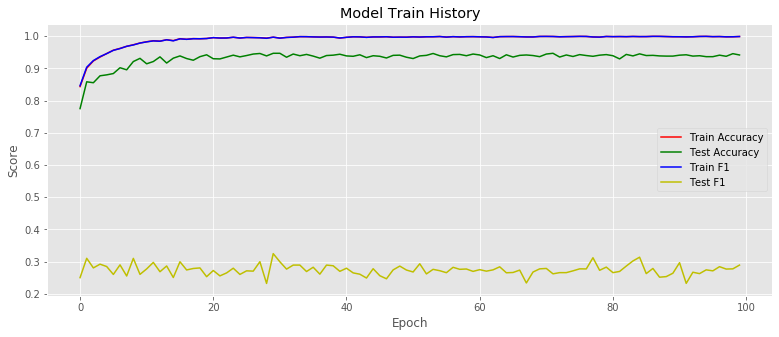

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,94.17,37.5,37.5,37.5,67.22,0.06,0.67,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1586   50]
 [  50   30]]


---> Splitting data (train/test)...
---> Training the `microwave` model...

Train on 10148 samples, validate on 1716 samples
Epoch 1/100
10148/10148 - 9s - loss: 0.1706 - accuracy: 0.9423 - f1: 0.9403 - val_loss: 0.0938 - val_accuracy: 0.9557 - val_f1: 0.9769
Epoch 2/100
10148/10148 - 8s - loss: 0.0851 - accuracy: 0.9760 - f1: 0.9741 - val_loss: 0.1241 - val_accuracy: 0.9569 - val_f1: 0.9774
Epoch 3/100
10148/10148 - 8s - loss: 0.0615 - accuracy: 0.9823 - f1: 0.9817 - val_loss: 0.1119 - val_accuracy: 0.9615 - val_f1: 0.9801
Epoch 4/100
10148/10148 - 8s - loss: 0.0438 - accuracy: 0.9873 - f1: 0.9866 - val_loss: 0.0718 - val_accuracy: 0.9773 - val_f1: 0.9883
Epoch 5/100
10148/10148 - 8s - loss: 0.0351 - accuracy: 0.9902 - f1: 0.9902 - val_loss: 0.0702 - val_accuracy: 0.9825 - val_f1: 0.9910
Epoch 6/100
10148/10148 - 8s - loss: 0.0284 - accuracy: 0.9936 - f1: 0.9934 - val_loss: 0.0900 - val_accuracy: 0.9755 - val

Epoch 60/100
10148/10148 - 8s - loss: 0.0012 - accuracy: 0.9997 - f1: 0.9965 - val_loss: 0.2374 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 61/100
10148/10148 - 8s - loss: 6.4281e-04 - accuracy: 0.9996 - f1: 0.9996 - val_loss: 0.2682 - val_accuracy: 0.9843 - val_f1: 0.9920
Epoch 62/100
10148/10148 - 8s - loss: 1.5792e-04 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.2726 - val_accuracy: 0.9843 - val_f1: 0.9920
Epoch 63/100
10148/10148 - 8s - loss: 0.0028 - accuracy: 0.9994 - f1: 0.9994 - val_loss: 0.2291 - val_accuracy: 0.9848 - val_f1: 0.9923
Epoch 64/100
10148/10148 - 8s - loss: 0.0012 - accuracy: 0.9996 - f1: 0.9996 - val_loss: 0.2153 - val_accuracy: 0.9825 - val_f1: 0.9910
Epoch 65/100
10148/10148 - 8s - loss: 0.0022 - accuracy: 0.9990 - f1: 0.9989 - val_loss: 0.2089 - val_accuracy: 0.9796 - val_f1: 0.9896
Epoch 66/100
10148/10148 - 8s - loss: 0.0012 - accuracy: 0.9998 - f1: 0.9998 - val_loss: 0.2580 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 67/100
10148/10148 - 8s - loss: 4.

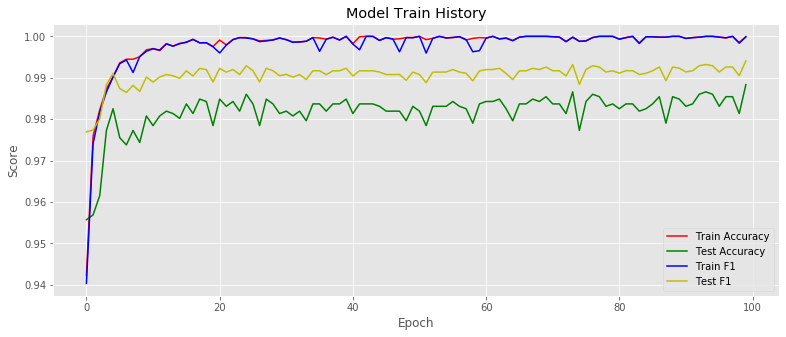

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,98.83,99.12,99.7,99.41,73.39,0.01,0.69,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[   9   15]
 [   5 1687]]



In [30]:
# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-oversampling_smote-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )
    
    # Resampling...
    X_train_resampled, y_train_resampled = SMOTE().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
        
    del X_train_resampled
    del y_train_resampled
    
    # Persisting model
    model.save("models/{}-{}-{}-oversampling_smote.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")


---> Splitting data (train/test)...
---> Training the `refrigerator` model...

Train on 8740 samples, validate on 1716 samples
Epoch 1/100
8740/8740 - 9s - loss: 0.5060 - accuracy: 0.7537 - f1: 0.7353 - val_loss: 0.3866 - val_accuracy: 0.8566 - val_f1: 0.9080
Epoch 2/100
8740/8740 - 7s - loss: 0.2830 - accuracy: 0.8833 - f1: 0.8764 - val_loss: 0.2720 - val_accuracy: 0.8840 - val_f1: 0.9270
Epoch 3/100
8740/8740 - 7s - loss: 0.1613 - accuracy: 0.9378 - f1: 0.9353 - val_loss: 0.4618 - val_accuracy: 0.8252 - val_f1: 0.8839
Epoch 4/100
8740/8740 - 7s - loss: 0.1180 - accuracy: 0.9565 - f1: 0.9548 - val_loss: 0.3157 - val_accuracy: 0.8998 - val_f1: 0.9375
Epoch 5/100
8740/8740 - 7s - loss: 0.0809 - accuracy: 0.9689 - f1: 0.9682 - val_loss: 0.2566 - val_accuracy: 0.9260 - val_f1: 0.9545
Epoch 6/100
8740/8740 - 7s - loss: 0.0727 - accuracy: 0.9737 - f1: 0.9697 - val_loss: 0.2486 - val_accuracy: 0.9295 - val_f1: 0.9566
Epoch 7/100
8740/8740 - 7s - loss: 0.0573 - accuracy: 0.9818 - f1: 0.9814 

Epoch 62/100
8740/8740 - 7s - loss: 0.0066 - accuracy: 0.9985 - f1: 0.9984 - val_loss: 0.6392 - val_accuracy: 0.9639 - val_f1: 0.9780
Epoch 63/100
8740/8740 - 7s - loss: 0.0072 - accuracy: 0.9979 - f1: 0.9978 - val_loss: 0.6121 - val_accuracy: 0.9662 - val_f1: 0.9794
Epoch 64/100
8740/8740 - 7s - loss: 0.0079 - accuracy: 0.9983 - f1: 0.9982 - val_loss: 0.5742 - val_accuracy: 0.9645 - val_f1: 0.9783
Epoch 65/100
8740/8740 - 7s - loss: 0.0077 - accuracy: 0.9983 - f1: 0.9984 - val_loss: 0.5355 - val_accuracy: 0.9650 - val_f1: 0.9790
Epoch 66/100
8740/8740 - 7s - loss: 0.0058 - accuracy: 0.9986 - f1: 0.9985 - val_loss: 0.5394 - val_accuracy: 0.9662 - val_f1: 0.9797
Epoch 67/100
8740/8740 - 7s - loss: 0.0103 - accuracy: 0.9974 - f1: 0.9974 - val_loss: 0.5124 - val_accuracy: 0.9592 - val_f1: 0.9752
Epoch 68/100
8740/8740 - 7s - loss: 0.0052 - accuracy: 0.9985 - f1: 0.9985 - val_loss: 0.5354 - val_accuracy: 0.9650 - val_f1: 0.9790
Epoch 69/100
8740/8740 - 7s - loss: 0.0035 - accuracy: 0.9989 

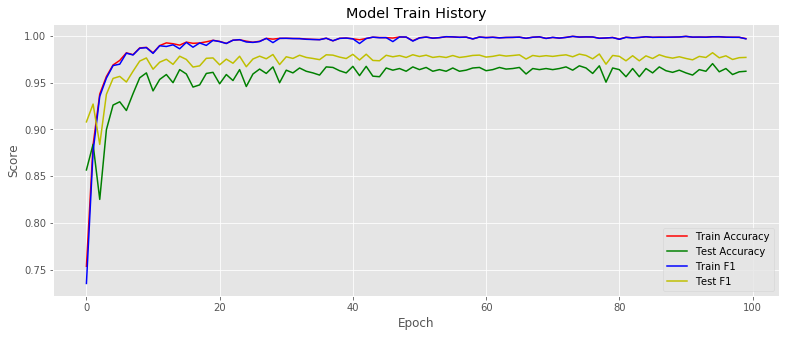

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,refrigerator,96.21,97.74,97.81,97.78,92.48,0.04,0.92,254,1462



CONFUSION MATRIX (OFF/ON):

 - refrigerator:
[[ 221   33]
 [  32 1430]]


---> Splitting data (train/test)...
---> Training the `dishwasher` model...

Train on 9533 samples, validate on 1716 samples
Epoch 1/100
9533/9533 - 9s - loss: 0.3944 - accuracy: 0.8301 - f1: 0.8089 - val_loss: 0.4016 - val_accuracy: 0.7838 - val_f1: 0.8666
Epoch 2/100
9533/9533 - 8s - loss: 0.3026 - accuracy: 0.8828 - f1: 0.8696 - val_loss: 0.3035 - val_accuracy: 0.8258 - val_f1: 0.8954
Epoch 3/100
9533/9533 - 8s - loss: 0.2566 - accuracy: 0.9050 - f1: 0.8955 - val_loss: 0.2670 - val_accuracy: 0.8526 - val_f1: 0.9133
Epoch 4/100
9533/9533 - 8s - loss: 0.2297 - accuracy: 0.9152 - f1: 0.9072 - val_loss: 0.3120 - val_accuracy: 0.8450 - val_f1: 0.9080
Epoch 5/100
9533/9533 - 8s - loss: 0.2021 - accuracy: 0.9251 - f1: 0.9178 - val_loss: 0.3035 - val_accuracy: 0.8695 - val_f1: 0.9247
Epoch 6/100
9533/9533 - 8s - loss: 0.1631 - accuracy: 0.9387 - f1: 0.9337 - val_loss: 0.2991 - val_accuracy: 0.8776 - val_f1: 0.9301
Ep

Epoch 61/100
9533/9533 - 8s - loss: 0.0084 - accuracy: 0.9958 - f1: 0.9958 - val_loss: 0.7786 - val_accuracy: 0.9207 - val_f1: 0.9571
Epoch 62/100
9533/9533 - 8s - loss: 0.0119 - accuracy: 0.9949 - f1: 0.9946 - val_loss: 0.7226 - val_accuracy: 0.9237 - val_f1: 0.9585
Epoch 63/100
9533/9533 - 7s - loss: 0.0060 - accuracy: 0.9976 - f1: 0.9974 - val_loss: 0.9123 - val_accuracy: 0.9225 - val_f1: 0.9580
Epoch 64/100
9533/9533 - 8s - loss: 0.0130 - accuracy: 0.9962 - f1: 0.9961 - val_loss: 0.8435 - val_accuracy: 0.9155 - val_f1: 0.9541
Epoch 65/100
9533/9533 - 8s - loss: 0.0080 - accuracy: 0.9970 - f1: 0.9968 - val_loss: 0.8323 - val_accuracy: 0.9178 - val_f1: 0.9550
Epoch 66/100
9533/9533 - 8s - loss: 0.0114 - accuracy: 0.9961 - f1: 0.9959 - val_loss: 0.8324 - val_accuracy: 0.9231 - val_f1: 0.9582
Epoch 67/100
9533/9533 - 7s - loss: 0.0102 - accuracy: 0.9963 - f1: 0.9961 - val_loss: 0.7919 - val_accuracy: 0.9155 - val_f1: 0.9532
Epoch 68/100
9533/9533 - 7s - loss: 0.0086 - accuracy: 0.9974 

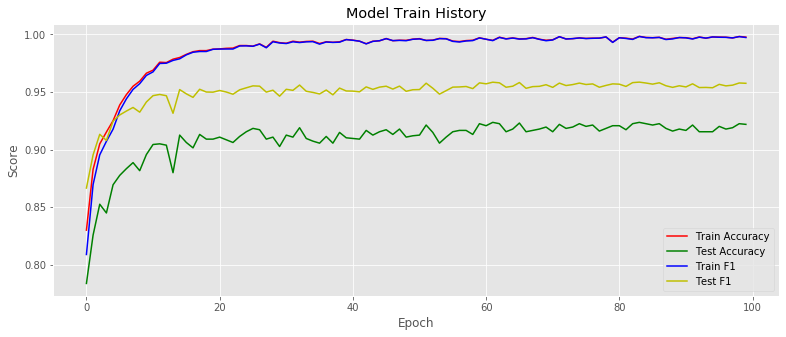

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,dishwasher,92.19,94.81,96.85,95.82,68.52,0.08,0.66,131,1585



CONFUSION MATRIX (OFF/ON):

 - dishwasher:
[[  47   84]
 [  50 1535]]


---> Splitting data (train/test)...
---> Training the `washer dryer 1` model...

Train on 9908 samples, validate on 1716 samples
Epoch 1/100
9908/9908 - 9s - loss: 0.3660 - accuracy: 0.8450 - f1: 0.8411 - val_loss: 0.3059 - val_accuracy: 0.8333 - val_f1: 0.2304
Epoch 2/100
9908/9908 - 8s - loss: 0.2286 - accuracy: 0.9173 - f1: 0.9188 - val_loss: 0.2340 - val_accuracy: 0.8817 - val_f1: 0.2722
Epoch 3/100
9908/9908 - 8s - loss: 0.1818 - accuracy: 0.9363 - f1: 0.9371 - val_loss: 0.2408 - val_accuracy: 0.8730 - val_f1: 0.2442
Epoch 4/100
9908/9908 - 8s - loss: 0.1518 - accuracy: 0.9483 - f1: 0.9480 - val_loss: 0.1732 - val_accuracy: 0.9132 - val_f1: 0.2595
Epoch 5/100
9908/9908 - 8s - loss: 0.1336 - accuracy: 0.9548 - f1: 0.9544 - val_loss: 0.3062 - val_accuracy: 0.8689 - val_f1: 0.2645
Epoch 6/100
9908/9908 - 8s - loss: 0.1107 - accuracy: 0.9619 - f1: 0.9613 - val_loss: 0.2130 - val_accuracy: 0.9085 - val_f1: 0.2193


Epoch 61/100
9908/9908 - 8s - loss: 0.0057 - accuracy: 0.9979 - f1: 0.9979 - val_loss: 0.4822 - val_accuracy: 0.9563 - val_f1: 0.2389
Epoch 62/100
9908/9908 - 8s - loss: 0.0052 - accuracy: 0.9985 - f1: 0.9986 - val_loss: 0.4477 - val_accuracy: 0.9545 - val_f1: 0.2136
Epoch 63/100
9908/9908 - 8s - loss: 0.0081 - accuracy: 0.9976 - f1: 0.9975 - val_loss: 0.4329 - val_accuracy: 0.9540 - val_f1: 0.2574
Epoch 64/100
9908/9908 - 8s - loss: 0.0048 - accuracy: 0.9988 - f1: 0.9988 - val_loss: 0.4042 - val_accuracy: 0.9575 - val_f1: 0.2333
Epoch 65/100
9908/9908 - 8s - loss: 0.0046 - accuracy: 0.9991 - f1: 0.9990 - val_loss: 0.5025 - val_accuracy: 0.9551 - val_f1: 0.1457
Epoch 66/100
9908/9908 - 8s - loss: 0.0037 - accuracy: 0.9990 - f1: 0.9989 - val_loss: 0.4297 - val_accuracy: 0.9580 - val_f1: 0.1975
Epoch 67/100
9908/9908 - 8s - loss: 0.0018 - accuracy: 0.9991 - f1: 0.9991 - val_loss: 0.5406 - val_accuracy: 0.9528 - val_f1: 0.2111
Epoch 68/100
9908/9908 - 8s - loss: 0.0106 - accuracy: 0.9972 

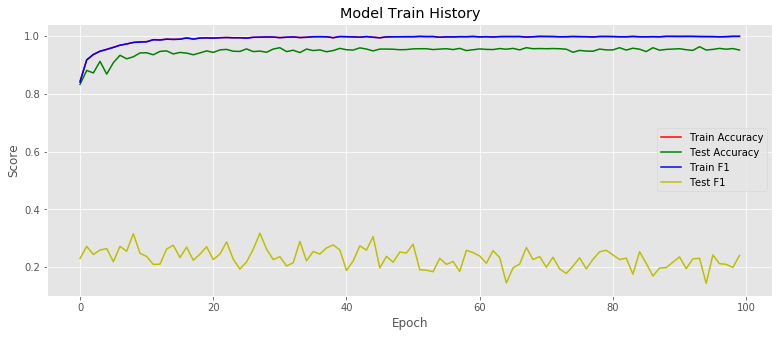

CLASSIFIER PERFORMANCE WASHER DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 1,95.22,34.38,35.48,34.92,66.22,0.05,0.66,1654,62



CONFUSION MATRIX (OFF/ON):

 - washer dryer 1:
[[1612   42]
 [  40   22]]


---> Splitting data (train/test)...
---> Training the `washer dryer 2` model...

Train on 9725 samples, validate on 1716 samples
Epoch 1/100
9725/9725 - 9s - loss: 0.4327 - accuracy: 0.8103 - f1: 0.8033 - val_loss: 0.3889 - val_accuracy: 0.7867 - val_f1: 0.2518
Epoch 2/100
9725/9725 - 8s - loss: 0.2883 - accuracy: 0.8911 - f1: 0.8949 - val_loss: 0.2631 - val_accuracy: 0.8497 - val_f1: 0.2982
Epoch 3/100
9725/9725 - 8s - loss: 0.2395 - accuracy: 0.9141 - f1: 0.9160 - val_loss: 0.2190 - val_accuracy: 0.8753 - val_f1: 0.3176
Epoch 4/100
9725/9725 - 8s - loss: 0.2029 - accuracy: 0.9261 - f1: 0.9278 - val_loss: 0.2902 - val_accuracy: 0.8578 - val_f1: 0.2830
Epoch 5/100
9725/9725 - 8s - loss: 0.1734 - accuracy: 0.9362 - f1: 0.9376 - val_loss: 0.2770 - val_accuracy: 0.8782 - val_f1: 0.3170
Epoch 6/100
9725/9725 - 8s - loss: 0.1402 - accuracy: 0.9454 - f1: 0.9445 - val_loss: 0.2715 - val_accuracy: 0.8916 - val_f1: 0.3

Epoch 61/100
9725/9725 - 8s - loss: 0.0150 - accuracy: 0.9948 - f1: 0.9946 - val_loss: 0.6414 - val_accuracy: 0.9347 - val_f1: 0.2559
Epoch 62/100
9725/9725 - 8s - loss: 0.0131 - accuracy: 0.9963 - f1: 0.9962 - val_loss: 0.5578 - val_accuracy: 0.9400 - val_f1: 0.2654
Epoch 63/100
9725/9725 - 8s - loss: 0.0155 - accuracy: 0.9955 - f1: 0.9953 - val_loss: 0.5316 - val_accuracy: 0.9435 - val_f1: 0.2765
Epoch 64/100
9725/9725 - 8s - loss: 0.0098 - accuracy: 0.9960 - f1: 0.9958 - val_loss: 0.4756 - val_accuracy: 0.9452 - val_f1: 0.3060
Epoch 65/100
9725/9725 - 8s - loss: 0.0126 - accuracy: 0.9968 - f1: 0.9967 - val_loss: 0.5005 - val_accuracy: 0.9388 - val_f1: 0.2783
Epoch 66/100
9725/9725 - 8s - loss: 0.0081 - accuracy: 0.9978 - f1: 0.9977 - val_loss: 0.6002 - val_accuracy: 0.9493 - val_f1: 0.2728
Epoch 67/100
9725/9725 - 8s - loss: 0.0112 - accuracy: 0.9966 - f1: 0.9965 - val_loss: 0.5208 - val_accuracy: 0.9429 - val_f1: 0.2798
Epoch 68/100
9725/9725 - 8s - loss: 0.0049 - accuracy: 0.9986 

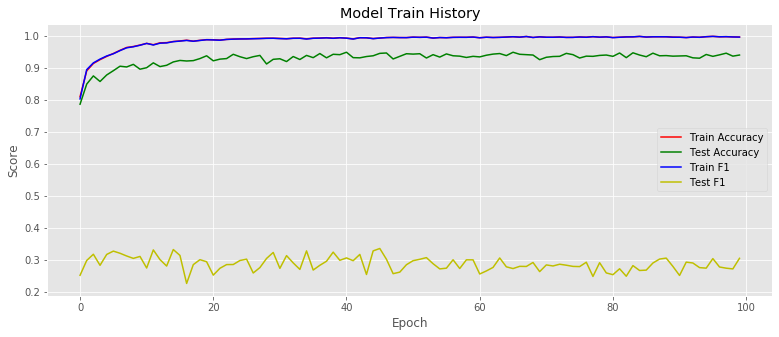

CLASSIFIER PERFORMANCE WASHER DRYER 2 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,washer dryer 2,94.06,38.04,43.75,40.7,68.78,0.06,0.7,1636,80



CONFUSION MATRIX (OFF/ON):

 - washer dryer 2:
[[1579   57]
 [  45   35]]


---> Splitting data (train/test)...
---> Training the `microwave` model...

Train on 10145 samples, validate on 1716 samples
Epoch 1/100
10145/10145 - 9s - loss: 0.1978 - accuracy: 0.9310 - f1: 0.9252 - val_loss: 0.1270 - val_accuracy: 0.9458 - val_f1: 0.9714
Epoch 2/100
10145/10145 - 8s - loss: 0.0940 - accuracy: 0.9723 - f1: 0.9676 - val_loss: 0.1120 - val_accuracy: 0.9557 - val_f1: 0.9770
Epoch 3/100
10145/10145 - 8s - loss: 0.0791 - accuracy: 0.9780 - f1: 0.9741 - val_loss: 0.0970 - val_accuracy: 0.9598 - val_f1: 0.9791
Epoch 4/100
10145/10145 - 8s - loss: 0.0656 - accuracy: 0.9807 - f1: 0.9763 - val_loss: 0.0932 - val_accuracy: 0.9656 - val_f1: 0.9822
Epoch 5/100
10145/10145 - 8s - loss: 0.0500 - accuracy: 0.9845 - f1: 0.9809 - val_loss: 0.0604 - val_accuracy: 0.9796 - val_f1: 0.9896
Epoch 6/100
10145/10145 - 8s - loss: 0.0419 - accuracy: 0.9880 - f1: 0.9840 - val_loss: 0.0860 - val_accuracy: 0.9738 - val

Epoch 60/100
10145/10145 - 8s - loss: 0.0027 - accuracy: 0.9990 - f1: 0.9990 - val_loss: 0.2293 - val_accuracy: 0.9866 - val_f1: 0.9932
Epoch 61/100
10145/10145 - 8s - loss: 0.0031 - accuracy: 0.9986 - f1: 0.9986 - val_loss: 0.2037 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 62/100
10145/10145 - 8s - loss: 0.0026 - accuracy: 0.9990 - f1: 0.9958 - val_loss: 0.1824 - val_accuracy: 0.9796 - val_f1: 0.9895
Epoch 63/100
10145/10145 - 8s - loss: 0.0025 - accuracy: 0.9993 - f1: 0.9993 - val_loss: 0.2241 - val_accuracy: 0.9837 - val_f1: 0.9917
Epoch 64/100
10145/10145 - 8s - loss: 0.0017 - accuracy: 0.9993 - f1: 0.9962 - val_loss: 0.2274 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 65/100
10145/10145 - 8s - loss: 0.0024 - accuracy: 0.9990 - f1: 0.9957 - val_loss: 0.2007 - val_accuracy: 0.9854 - val_f1: 0.9926
Epoch 66/100
10145/10145 - 8s - loss: 0.0017 - accuracy: 0.9992 - f1: 0.9961 - val_loss: 0.2377 - val_accuracy: 0.9860 - val_f1: 0.9929
Epoch 67/100
10145/10145 - 8s - loss: 8.8497e-04

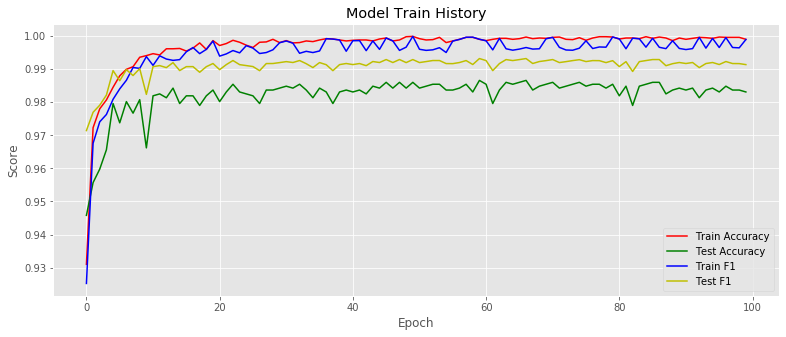

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,microwave,98.31,99.11,99.17,99.14,68.72,0.02,0.68,24,1692



CONFUSION MATRIX (OFF/ON):

 - microwave:
[[   9   15]
 [  14 1678]]



In [31]:


# Model fit...
for i in range(labels_binary.shape[1]):
    
#     log_dir = os.path.join(
#         "logs",
#         "fit",
#         datetime.now().strftime("%Y%m%d-%H%M%S"),
#     )#"./logs/{}".format(time())
#     tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks_ = [
#         EarlyStopping(
#             monitor = 'val_f1', 
#             mode='max',
#             patience = 100
#         ),
        ModelCheckpoint(
            filepath="models/{}-{}-{}-oversampling_adasyn-best.h5".format("rp", "binary", valid_appliances[i]), 
            monitor='val_f1', 
            save_best_only=True
        )
    ]
    
    print("")
    print("---> Splitting data (train/test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        series_images, labels_binary[:, i],
        stratify = labels_binary[:, i],
        random_state=SEED, test_size=TEST_SIZE#, shuffle=True
    )
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        X_train.reshape(X_train.shape[0], -1),
        y_train
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(X_train.shape[1:]))
                )
    
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = dcnn_appliance()#input_shape_=X_train[0,:,:].shape)
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test, y_test), 
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose = 2, callbacks = callbacks_
    )
        
    del X_train_resampled
    del y_train_resampled
    
    # Persisting model
    model.save("models/{}-{}-{}-oversampling_adasyn.h5".format("rp", "binary", valid_appliances[i]))
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test, y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# # UNDERSAMPLING NO TESTE (???)
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# # Model fit...
# for i in range(y_train.shape[1]):
#     print("---> Training the `{}` model...\n".format(valid_appliances[i]))
#     #model = cnn_model(output_layer_length=1)
#     model = dcnn_appliance()
    
#     # Resampling...
#     X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
#         X_train.reshape(X_train.shape[0], -1),
#         y_train[:, i]
#     )
#     X_train_resampled = X_train_resampled.reshape(
#                     tuple(list([-1]) + list(X_train.shape[1:]))
#                 )
#     X_test_resampled, y_test_resampled = RandomUnderSampler().fit_resample(
#         test_rp_images.reshape(X_test.shape[0], -1),
#         y_test[:, i]
#     )
#     X_test_resampled = X_test_resampled.reshape(
#                     tuple(list([-1]) + list(X_test.shape[1:]))
#                 )
    
#     # Calibrating model..
#     callback = model.fit(
#         X_train_resampled, y_train_resampled,
#         validation_data=(X_test_resampled, y_test_resampled), 
#         epochs=100, batch_size=32,
#         verbose = 2, callbacks = [tbCallback]#, callbacks = [tqdm_callback]
#     )
    
#     # Plot metrics...
#     fig = plt.figure(figsize=(13,5))
#     line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
#     line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
#     line_f1_m = plt.plot(callback.history["f1"], label = "Train F1", color = "b")
#     line_val_f1_m = plt.plot(callback.history["val_f1"], label = "Test F1", color = "y")
#     plt.title("Model Train History")
#     plt.xlabel("Epoch")
#     plt.ylabel("Score")
#     plt.legend()
#     plt.show()

#     # Final report (validated on test set)
#     y_pred = np.array(model.predict(X_test_resampled).round())
#     classification_report_appliance(y_test_resampled, y_pred, label = valid_appliances[i])
    
#     print("")
    
#     del X_train_resampled
#     del y_train_resampled
#     del X_test_resampled
#     del y_test_resampled

# Amostras de Imagens Individuais

Appliance `refrigerator`:


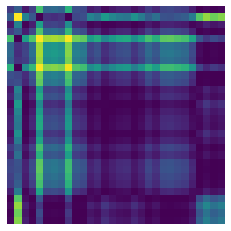

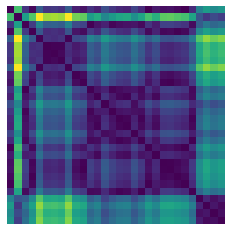

In [35]:
idx_appliance = 0

index = np.where(
    (labels_binary[:, idx_appliance] == 1) & 
    (labels_binary[:, 1] == 0) & (labels_binary[:, 2] == 0) &
    (labels_binary[:, 3] == 0) 
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(gaf_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(rp_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `dishwasher`:


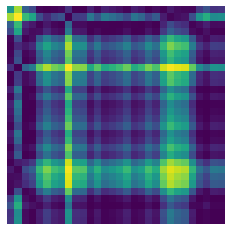

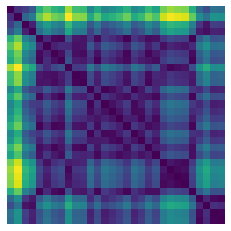

In [36]:
idx_appliance = 1

index = np.where(
    (labels_binary[:, idx_appliance] == 1) & 
    (labels_binary[:, 0] == 0) & (labels_binary[:, 2] == 0) &
    (labels_binary[:, 3] == 0) & (labels_binary[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(gaf_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(rp_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `washer dryer 1`:


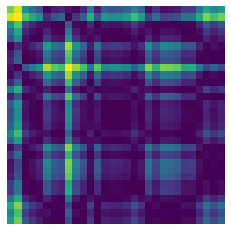

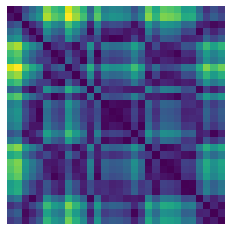

In [37]:
idx_appliance = 2

index = np.where(
    (labels_binary[:, idx_appliance] == 1) & 
    (labels_binary[:, 0] == 0) & (labels_binary[:, 1] == 0) 
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(gaf_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(rp_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `washer dryer 2`:


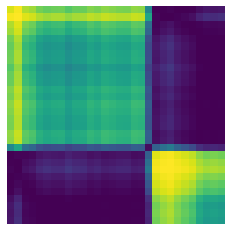

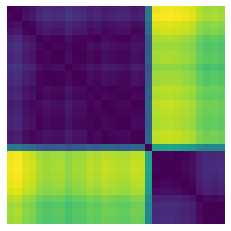

In [38]:
idx_appliance = 3

index = np.where(
    (labels_binary[:, idx_appliance] == 1) & 
    (labels_binary[:, 0] == 0) & (labels_binary[:, 1] == 0) &
    (labels_binary[:, 2] == 0) 
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(gaf_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(rp_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `microwave`:


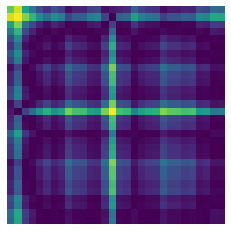

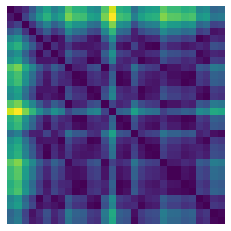

In [39]:
idx_appliance = 4

index = np.where(
    (labels_binary[:, idx_appliance] == 1) & 
    (labels_binary[:, 0] == 0) & (labels_binary[:, 1] == 0) &
    (labels_binary[:, 2] == 0) & (labels_binary[:, 3] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(gaf_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(rp_images[index,:,:,:])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

# Análise Adicional dos Dados

In [ ]:
yb1_train.shape

In [ ]:
for i, appliance in enumerate(valid_appliances):
    y_i = yb1_train[:, i]
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]
    print(appliance, 
          "-> Suport OFF (y=0):", supp_0, "({}%)".format( round((supp_0/yb1_train.shape[0])*100,2) ),
          "/ Support ON (y=1):", supp_1, "({}%)".format( round((supp_1/yb1_train.shape[0])*100,2) ),
          "\n"
         )


# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# x, y = ... # load your data
# datagen = ImageDataGenerator()
# balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

# model = ... # define your model
# model.compile(...) # define your compile parameters
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

In [ ]:
RecurrencePlot().fit_transform(tra)

In [ ]:
# datagen = ImageDataGenerator()

# steps_per_epoch = balanced_gen.steps_per_epoch

from imblearn.keras import BalancedBatchGenerator
# >>> from imblearn.under_sampling import NearMiss
# >>> training_generator = BalancedBatchGenerator(
# ...     X, y, sampler=NearMiss(), batch_size=10, random_state=42)
# >>> callback_history = model.fit_generator(generator=training_generator,
# ...                                        epochs=10, verbose=0)


balanced_gen = BalancedBatchGenerator(
    train_rp_images, 
    yb1_train[:, 1], 
    sampler=RandomOverSampler(), 
    batch_size=32,
    random_state = 33
)

model = cnn_model_appliance()
# Calibrating model..
callback = model.fit_generator(
    balanced_gen, 
    steps_per_epoch, 
    epochs = 100, 
    verbose = 2, 
    use_multiprocessing = True,
    workers = 6
)

# # Calibrating model..
# callback = model.fit_generator(
#     BalancedDataGenerator(
#         train_rp_images, 
#         yb1_train[:, 1], # Applaicne 1
#         ImageDataGenerator(), 
#         batch_size=32
#     ), 
#     epochs=100,
#     verbose = 2#, callbacks = [tqdm_callback]
# )  

In [ ]:
X_ = RecurrencePlot().fit_transform(np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') ))

In [ ]:
for x in X:
    print(x.reshape((1,) + x.shape).shape)
    break

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, class_dict)
X = X_
import tensorflow.keras as keras
y = keras.utils.to_categorical(y, 3)
model = keras.models.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                              activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
               metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
     X, y, sampler=RandomOverSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                        epochs=10, verbose=0)

In [ ]:
X.shape

In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
del train_gaf_images
del test_gaf_images
del train_rp_images
del test_rp_images
del power_chunks

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.